### **Set up the working environment**

#### **Imports**

In [ ]:
!pip3 install pyro-ppl

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as grdsp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pyro
import pyro.distributions as dist
from pyro.contrib.bnn import HiddenLayer
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

#### **Plotting settings**

In [ ]:
import matplotlib.font_manager as fm

!wget "https://fonts.google.com/download?family=Open%20Sans" -O "/content/Open_Sans.zip"
!unzip "/content/Open_Sans.zip" -d "/content/Open_Sans"
!mv "/content/Open_Sans/" "/usr/share/fonts/truetype/Open_Sans/"
!rm "/content/Open_Sans.zip"
regular_font_path = '/usr/share/fonts/truetype/Open_Sans/OpenSans-Regular.ttf'
bold_font_path = '/usr/share/fonts/truetype/Open_Sans/OpenSans-Bold.ttf'

title_font = fm.FontProperties(fname=regular_font_path)
title_font.set_size(18)
title_font.set_style('normal')
titleL_font = fm.FontProperties(fname=regular_font_path)
titleL_font.set_size(32)
titleL_font.set_style('normal')
titleXL_font = fm.FontProperties(fname=regular_font_path)
titleXL_font.set_size(36)
titleXL_font.set_style('normal')

labels_font = fm.FontProperties(fname=regular_font_path)
labels_font.set_size(14)
labels_font.set_style('normal')
labelsB_font = fm.FontProperties(fname=bold_font_path)
labelsB_font.set_size(14)
labelsB_font.set_style('normal')

text_font = fm.FontProperties(fname=regular_font_path)
text_font.set_size(12)
text_font.set_style('normal')
textS_font = fm.FontProperties(fname=regular_font_path)
textS_font.set_size(10)
textS_font.set_style('normal')
textB_font = fm.FontProperties(fname=bold_font_path)
textB_font.set_size(12)
textB_font.set_style('normal')

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

class ColorScheme:
    def __init__(self):
        self.coral = '#f56958'
        self.yellow = '#f6e813'
        self.lilac = '#a051a0'
        self.cream = '#fef6e9'
        self.dark = '#1a1416'

class GradientColorMap:
    def __init__(self, colors: list):
        self.colors = colors
        self.name = 'gradient_cmap'
        self.num_bins = 100

    def get_cmap(self):
        cmap = LinearSegmentedColormap.from_list(self.name, self.colors, self.num_bins)
        return cmap
    
colors_ = ColorScheme()
gradient_map = GradientColorMap([colors_.dark + 'bf', colors_.coral])
plot_cmap = gradient_map.get_cmap()

# **Multiclass Classification**

### **Define utility functions**

In [ ]:
# Setting up GPU

use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
# Define functions for train and evaluation

def train_dnn(model, train_loader, criterion, optimizer, epoch):
    train_loss = []
    train_acc = []

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.long()
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        train_loss.append(loss.data.numpy())  

        predictions = output.argmax(dim=1)
        train_acc.append(predictions.eq(target.view_as(predictions)).float())

        optimizer.step()

    train_loss = np.array(train_loss).mean()
    train_acc  = torch.stack(train_acc, dim=0)
    b, s = train_acc.shape
    train_acc = train_acc.view(-1, b*s).mean()
    
    return train_loss, train_acc

def train_bnn(train_loader, svi, epoch):
    train_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):  
        loss = svi.step(data, target)
        train_loss.append(loss) 

    train_loss = np.array(train_loss).mean()
    train_acc = evaluate_bnn(svi.guide, train_loader)

    return train_loss, train_acc


def evaluate_bnn(guide, data_loader, num_samples=8):
    accuracy = []

    for (data, target) in data_loader:
        ts = [pyro.poutine.trace(guide(None)).get_trace(data) for _ in range(num_samples)]
        predictions = [t.nodes['_RETURN']['value'] for t in ts]
        predictions = torch.stack(predictions).mean(dim=0)
        predictions = predictions.argmax(-1)

        accuracy.append(predictions.eq(target.view_as(predictions)).float())

    accuracy = torch.stack(accuracy, dim=0)
    b, s = accuracy.shape
    accuracy = accuracy.view(-1, b*s).mean()

    return accuracy

In [ ]:
# Function to compute classification performance stats

def compute_performance_dnn(model, test_loader): 

    true_labels = []
    pred_labels = []
    test_data = []

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, output = torch.max(output, 1)

            true_labels.extend(target.detach().numpy())
            pred_labels.extend(output.detach().numpy())
            test_data.extend(data.detach().numpy())

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    test_data = np.array(test_data)

    conf_matrix = confusion_matrix(true_labels, pred_labels)

    labels = ['0', '1', '2']
    print(classification_report(true_labels, pred_labels,
                                target_names=labels))

    report = classification_report(true_labels, pred_labels,
                                   target_names=labels, output_dict=True)
    metrics_dict = {'true_labels': true_labels,
                    'pred_labels': pred_labels,
                    'test_data': test_data,
                    'accuracy': report['accuracy'],
                    'class_f1_score': [report[l]['f1-score'] for l in labels],
                    'conf_matrix': conf_matrix}

    return metrics_dict
    

def compute_performance_bnn(guide, data_loader, num_samples=8):

    true_labels = []
    pred_labels = []
    test_data = []

    for (data, target) in data_loader:
        models = [guide(None) for _ in range(num_samples)]
        predictions = [model(data).data for model in models]
        predictions = torch.stack(predictions).mean(dim=0)
        predictions = predictions.argmax(-1)

        test_data.extend(data.numpy())
        true_labels.extend(target.numpy())
        pred_labels.extend(predictions.numpy())

    test_data = np.array(test_data)
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    conf_matrix = confusion_matrix(true_labels, pred_labels)

    labels = ['0', '1', '2']
    print(classification_report(true_labels, pred_labels,
                                target_names=labels))

    report = classification_report(true_labels, pred_labels,
                                   target_names=labels, output_dict=True)
    metrics_dict = {'true_labels': true_labels,
                    'pred_labels': pred_labels,
                    'test_data': test_data,
                    'accuracy': report['accuracy'],
                    'class_f1_score': [report[l]['f1-score'] for l in labels],
                    'conf_matrix': conf_matrix}

    return metrics_dict

In [ ]:
# Function to display the confusion matrix

def plot_confusion_matrix(ax, conf_matrix, title=None):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    conf_img = ax.imshow(conf_matrix, cmap=plot_cmap, aspect='equal', )
    for idx_row, row in enumerate(conf_matrix):
        for idx_col, col in enumerate(row):
            y = idx_row
            x = idx_col
            ax.text(x, y, str(col), ha='center', va='center',
                    fontproperties=labelsB_font, color='white')

    xticks = []
    ax.set_xticks(xticks)
    yticks = []
    ax.set_yticks(yticks)

    labels = ['0', '1', '2']
    for idx_label, label in enumerate(labels):
        vertical_x = -.55
        vertical_y = idx_label
        ax.text(vertical_x, vertical_y, label, ha='right', va='center',
                    fontproperties=labelsB_font, color=colors_.dark+'bf')
        
        horizontal_x = idx_label
        horizontal_y = -.55
        ax.text(horizontal_x, horizontal_y, label, ha='center', va='bottom',
                    fontproperties=labelsB_font, color=colors_.dark+'bf')

    if title is not None:
        ax.set_title('{:s}\n'.format(title.upper()), fontproperties=title_font,
                     color=colors_.dark+'bf')

In [ ]:
# Function to plot losses

def plot_loss(axis, bnn_loss, dnn_loss, plot_dict=None): 

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    bg_color = colors_.dark + 'bf'
    axis.set_facecolor(bg_color) 

    bnn_plot = axis.plot(bnn_loss, color=colors_.cream, lw=.5)
    dnn_plot = axis.plot(dnn_loss, color=colors_.coral, lw=1)

    xlim = axis.get_xlim()
    axis.set_xticklabels([str(int(tick)) for tick in axis.get_xticks()],
                         fontproperties=text_font, color=bg_color)
    
    
    ylim = [int(min(bnn_loss.min(), dnn_loss.min())-.5),
            int(max(bnn_loss.max(), dnn_loss.max())+.5)]
    yticks = np.linspace(ylim[0], ylim[1], num=6, endpoint=True)
    axis.set_ylim([ylim[0]-1, ylim[1]+1]) 
    axis.set_yticks(yticks)
    axis.set_yticklabels([str('{:.2f}'.format(tick)) for tick in yticks],
                         fontproperties=text_font, color=bg_color)

    axis.tick_params(axis='both', color='black', length=3, width=.75)
    legend = axis.legend(['BNN loss', 'DNN loss'], prop=text_font, framealpha=.5)

In [ ]:
# Function to plot accuracies

def plot_accuracies(axis, bnn_acc, dnn_acc, plot_dict=None):  

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    bg_color = colors_.dark + 'bf'
    axis.set_facecolor(bg_color) 
    
    bnn_plot = axis.plot(bnn_acc, color=colors_.cream, lw=.5)
    dnn_plot = axis.plot(dnn_acc, color=colors_.coral, lw=1)
    
    xlim = axis.get_xlim()    
    axis.set_xticklabels([str(int(tick)) for tick in axis.get_xticks()],
                         fontproperties=text_font, color=bg_color)
    
    ylim = [int(min(bnn_acc.min(), dnn_acc.min())),
            int(max(bnn_acc.max(), dnn_acc.max()))]
    yticks = np.linspace(ylim[0], ylim[1], num=6, endpoint=True)
    axis.set_ylim([ylim[0]-5, ylim[1]+5]) 
    axis.set_yticks(yticks)
    axis.set_yticklabels([str('{:.2f}'.format(tick)) for tick in yticks],
                         fontproperties=text_font, color=bg_color)

    axis.tick_params(axis='both', color='black', length=3, width=.75)
    legend = axis.legend(['BNN acc', 'DNN acc'], prop=text_font, framealpha=.5)

In [ ]:
# Function to display prior and posterior probability distributions

from scipy.stats import norm

def display_posterior_pdf(axis, param_name,
                          loc_post, scale_post,
                          prior_value=None, loc_prior=None, scale_prior=None,
                          inter_loc=None, inter_scale=None):   

    
    alphas = ['0d', '1a', '26', '33', '40', '4d', '59', '66', '73']     
    for idx, (l, s) in enumerate(zip(inter_loc, inter_scale)):
        sample_ = np.random.normal(loc=l, scale=s, size=1000)
        x_ = np.linspace(sample_.min(), sample_.max(), num=128, endpoint=True)
        pdf_ = norm.pdf(x_, loc=l, scale=s)

        inter_plot  = axis.plot(x_, pdf_, color=colors_.coral+alphas[idx], lw=1)
    
    sample_post = np.random.normal(loc=loc_post, scale=scale_post, size=1000)
    x_post = np.linspace(sample_post.min(), sample_post.max(), num=128, endpoint=True)
    pdf_post = norm.pdf(x_post, loc=loc_post, scale=scale_post)

    post_plot,  = axis.plot(x_post, pdf_post, color=colors_.coral, lw=1)
    legend_text = ['{:s} POSTERIOR'.format(param_name)]
    legend_h = [post_plot]

    if loc_prior is not None:
        sample_prior = np.random.normal(loc=loc_prior, scale=scale_prior, size=1000)
        x_prior = np.linspace(sample_prior.min(), sample_prior.max(), num=128, endpoint=True)
        pdf_prior = norm.pdf(x_prior, loc=loc_prior, scale=scale_prior)

        prior_plot, = axis.plot(x_prior, pdf_prior, color=colors_.cream, lw=1)        
        legend_text.append('{:s} PRIOR'.format(param_name))
        legend_h.append(prior_plot)
    
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.set_aspect('auto')
    bg_color = colors_.dark + 'bf'
    axis.set_facecolor(bg_color) 

    xlim = axis.get_xlim()
    axis.set_xticklabels(['{:.2f}'.format(tick) for tick in axis.get_xticks()],
                         fontproperties=textS_font, color=bg_color)
    ylim = [0, axis.get_ylim()[1]] 
    axis.set_ylim(ylim)
    yticks = np.linspace(ylim[0], ylim[1], 6)
    axis.set_yticks(yticks)
    axis.set_yticklabels(['{:.2f}'.format(tick) for tick in axis.get_yticks()],
                         fontproperties=textS_font, color=bg_color)

    axis.tick_params(axis='both', color=bg_color, length=3, width=.75)
    
    if prior_value is not None:
        sampled_weight, = axis.plot([prior_value, prior_value], ylim, 
                                    color=colors_.lilac, ls='--', lw=1.5)
        legend_text.append('prior {:s} = {:.2f}'.format(param_name.split('-')[1],
                                                        prior_value))
        legend_h.append(sampled_weight)
    
    axis.legend(legend_h, legend_text, prop=textS_font, framealpha=.5)
    title1 = 'Prior {:s}{:s}({:.2f}, {:.2f})'.format(param_name, '$\sim \mathcal{N}$', 
                                               loc_prior, scale_prior)
    title2 = 'Posterior {:s}{:s}({:.2f}, {:.2f})'.format(param_name, '$\sim \mathcal{N}$', 
                                               loc_post, scale_post)
    axis.set_title('{:s}\n{:s}'.format(title1, title2),
                   fontproperties=labels_font, color=bg_color)  

### **Data Processing**

In [ ]:
# Generate data

def generate_multiclass_data(num_samples):
    loc = np.array([[-1, -1],
                    [1, 0],
                    [-.5, 1.5]])
    scale = np.array([[.5, .5],
                      [.5, .5],
                      [.5, .5]])
    clusters = np.array([0, 1, 2])

    num_clusters = len(clusters)
    labels = np.random.randint(0, num_clusters, size=num_samples)
    data = np.random.normal([loc[l] for l in labels], [scale[l] for l in labels], 
                            size=(num_samples, 2))
    labels = clusters[labels]

    return data, labels

def visualize_multiclass_data(ax, data, labels, title, 
                       colors=np.array([colors_.coral, colors_.cream, colors_.lilac])):   

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')

    bg_color = colors_.dark + 'bf'
    ax.set_facecolor(bg_color)

    ticks = [-2, -1, 0, 1, 2]
    lims = [-3, 3]
    ax.set_xlim(lims)
    ax.set_xticks(ticks)
    ax.set_xticklabels(['{:d}'.format(t) for t in ticks], 
                       fontproperties=text_font, color=bg_color)
    ax.set_ylim(lims)
    ax.set_yticks(ticks)
    ax.set_yticklabels(['{:d}'.format(t) for t in ticks], 
                       fontproperties=text_font, color=bg_color)
    ax.tick_params(axis='both', color=bg_color, length=3, width=.75)
    
    # ax.vlines(0, ymin=-3, ymax=3, color=colors_.dark, lw=.35, ls='-.')
    # ax.hlines(0, xmin=-3, xmax=3, color=colors_.dark, lw=.35, ls='-.')

    xor_plot = ax.scatter(data[:, 0], data[:, 1], c=colors[labels], s=10, 
                          zorder=7)

    if title is not None:
        ax.set_title('{:s}'.format(title.upper()), fontproperties=title_font, 
                    color=bg_color)

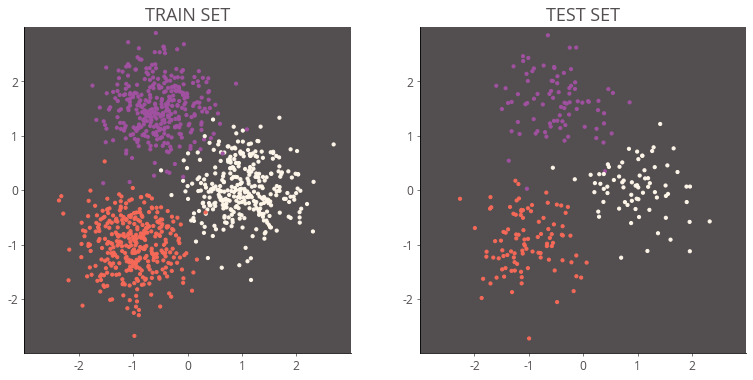

In [ ]:
# Create train and test sets

train_data, train_labels = generate_multiclass_data(1024)
test_data, test_labels = generate_multiclass_data(256)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_multiclass_data(ax[0], train_data, train_labels, 'train set')
visualize_multiclass_data(ax[1], test_data, test_labels, 'test set')

In [ ]:
# Convert data to tensor

train_data, train_labels = map(torch.tensor, (train_data.astype(np.float32),
                                              train_labels.astype(np.float32)))
test_data, test_labels = map(torch.tensor, (test_data.astype(np.float32), 
                                            test_labels.astype(np.float32)))

print('Train Set : %4d samples - %s' % (len(train_data), str(train_data.shape)))
print(' Test Set : %4d samples - %s' % (len(test_data), str(test_data.shape)))

Train Set : 1024 samples - torch.Size([1024, 2])
 Test Set :  256 samples - torch.Size([256, 2])


In [ ]:
# Creating Dataloaders

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(train_loader))
print(' Test batches : %d' % len(test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=torch.zeros(self.hid_size, self.in_size),
                                  scale=torch.ones(self.hid_size, self.in_size))
        _fc1b_prior = dist.Normal(loc=torch.zeros(self.hid_size),
                                  scale=torch.ones(self.hid_size))
        
        _fc2w_prior = dist.Normal(loc=torch.zeros(self.out_size, self.hid_size),
                                  scale=torch.ones(self.out_size, self.hid_size))
        _fc2b_prior = dist.Normal(loc=torch.zeros(self.out_size),
                                  scale=torch.ones(self.out_size))
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                       '_fc1.bias': _fc1b_prior,
                       '_fc2.weight': _fc2w_prior,
                       '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                           '_fc1.bias': _fc1b_posterior,
                           '_fc2.weight': _fc2w_posterior,
                           '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.SGD(model_dnn.parameters(),
                                 lr=.01, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

model_bdnn = DNN(2, 4, 3)
bnn_ = BNN(model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.SGD({'lr': .001})
svi = SVI(bnn_.model_bnn, bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

train_data_dnn = {'train_loss': [], 'train_acc': []}
train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    if epoch == 500: 
        optimizer_bnn = pyro.optim.SGD({'lr': .0001})
        svi = SVI(bnn_.model_bnn, bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

    train_loss_dnn, train_acc_dnn = train_dnn(model_dnn, train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(train_loader, svi, epoch)
    
    train_data_dnn['train_loss'].append(train_loss_dnn)
    train_data_dnn['train_acc'].append(train_acc_dnn)

    train_data_bnn['train_loss'].append(train_loss_bnn)
    train_data_bnn['train_acc'].append(train_acc_bnn)
    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.1399128   |   acc: 0.3554688
   BNN loss:  535.4839010   |   acc: 0.6357422

EPOCH 100
   DNN loss:    0.2219523   |   acc: 0.9765625
   BNN loss:   39.6219683   |   acc: 0.9804688

EPOCH 200
   DNN loss:    0.0952455   |   acc: 0.9853516
   BNN loss:   36.7062218   |   acc: 0.9843750

EPOCH 300
   DNN loss:    0.0762348   |   acc: 0.9863281
   BNN loss:   37.7597812   |   acc: 0.9824219

EPOCH 400
   DNN loss:    0.0699314   |   acc: 0.9863281
   BNN loss:   42.1243318   |   acc: 0.9824219

EPOCH 500
   DNN loss:    0.0672199   |   acc: 0.9853516
   BNN loss:   33.9132257   |   acc: 0.9794922

EPOCH 600
   DNN loss:    0.0659170   |   acc: 0.9853516
   BNN loss:   37.9772749   |   acc: 0.9843750

EPOCH 700
   DNN loss:    0.0652604   |   acc: 0.9853516
   BNN loss:   39.6406297   |   acc: 0.9843750

EPOCH 800
   DNN loss:    0.0649242   |   acc: 0.9853516
   BNN loss:   35.7249064   |   acc: 0.9833984

EPOCH 900
   DNN loss:    0.0647530   |   acc: 0.985351

In [ ]:
ps =  pyro.get_param_store()
bnn_params_store = dict()
for key, param in ps.items():
    bnn_params_store[key] = param.detach().clone()

### **Performance**

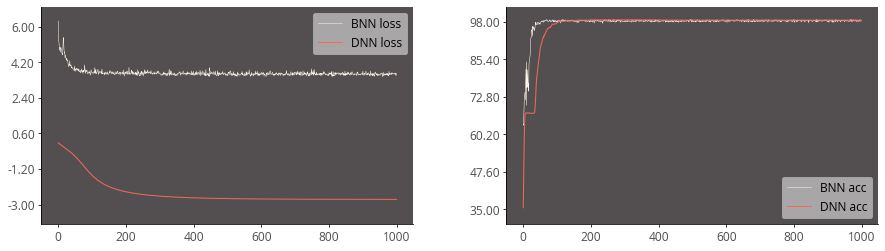

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
metrics_dnn = compute_performance_dnn(model_dnn, test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
metrics_bnn = compute_performance_bnn(bnn_.guide_bnn, test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.96      0.99      0.97        73
           2       0.99      0.95      0.97        84

    accuracy                           0.98       256
   macro avg       0.98      0.98      0.98       256
weighted avg       0.98      0.98      0.98       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.99      0.97      0.98        73
           2       0.98      0.98      0.98        84

    accuracy                           0.98       256
   macro avg       0.98      0.98      0.98       256
weighted avg       0.98      0.98      0.98       256



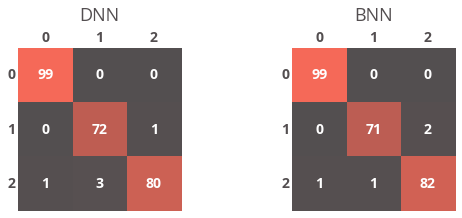

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(9, 3))

plot_confusion_matrix(ax[0], metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], metrics_bnn['conf_matrix'], 'bnn')

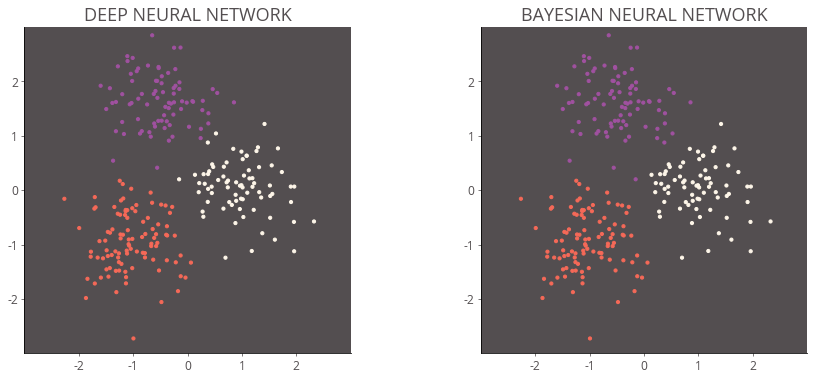

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], metrics_dnn['test_data'], metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], metrics_bnn['test_data'], metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

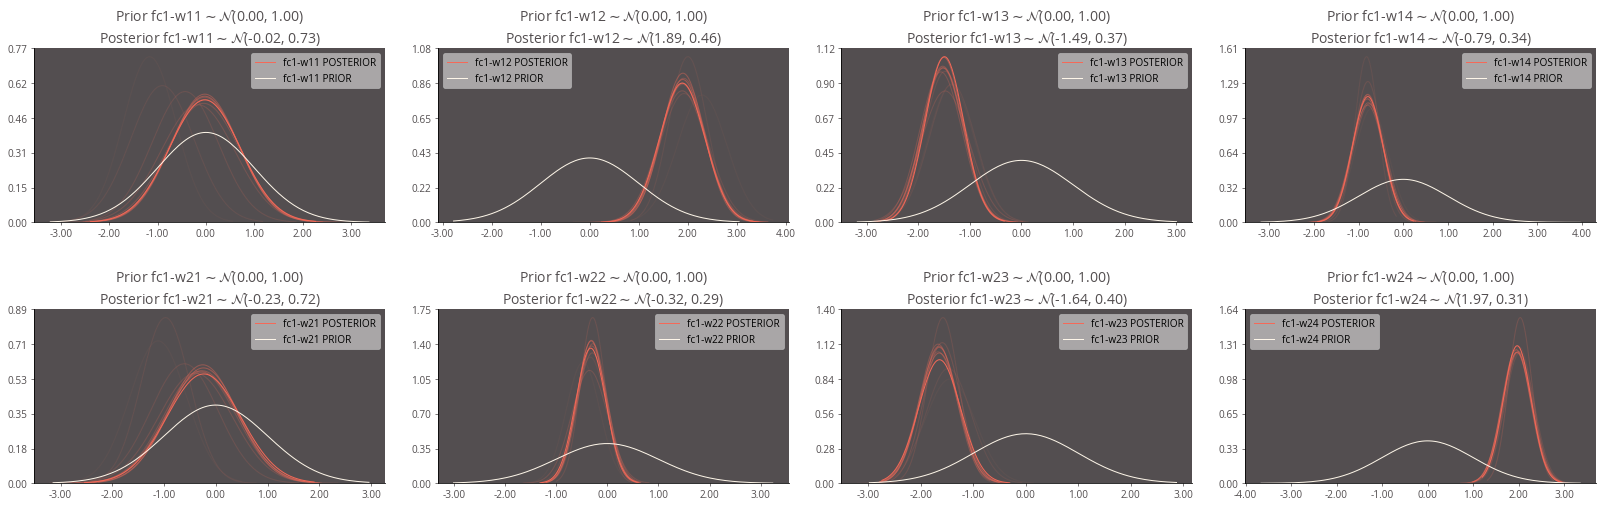

In [ ]:
# FC1 weights

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = bnn_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(bnn_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = 0, 1
        prior_value = None

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

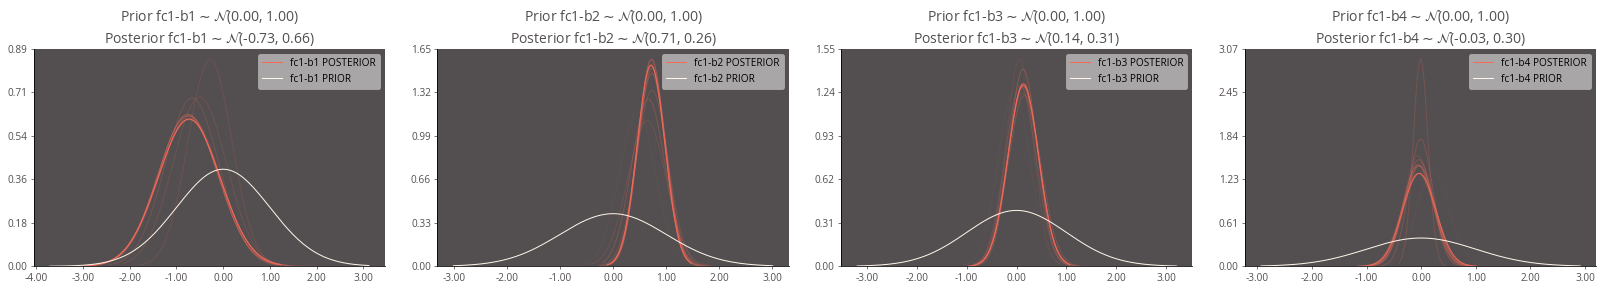

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = bnn_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(bnn_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = 0, 1
    prior_value = None

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

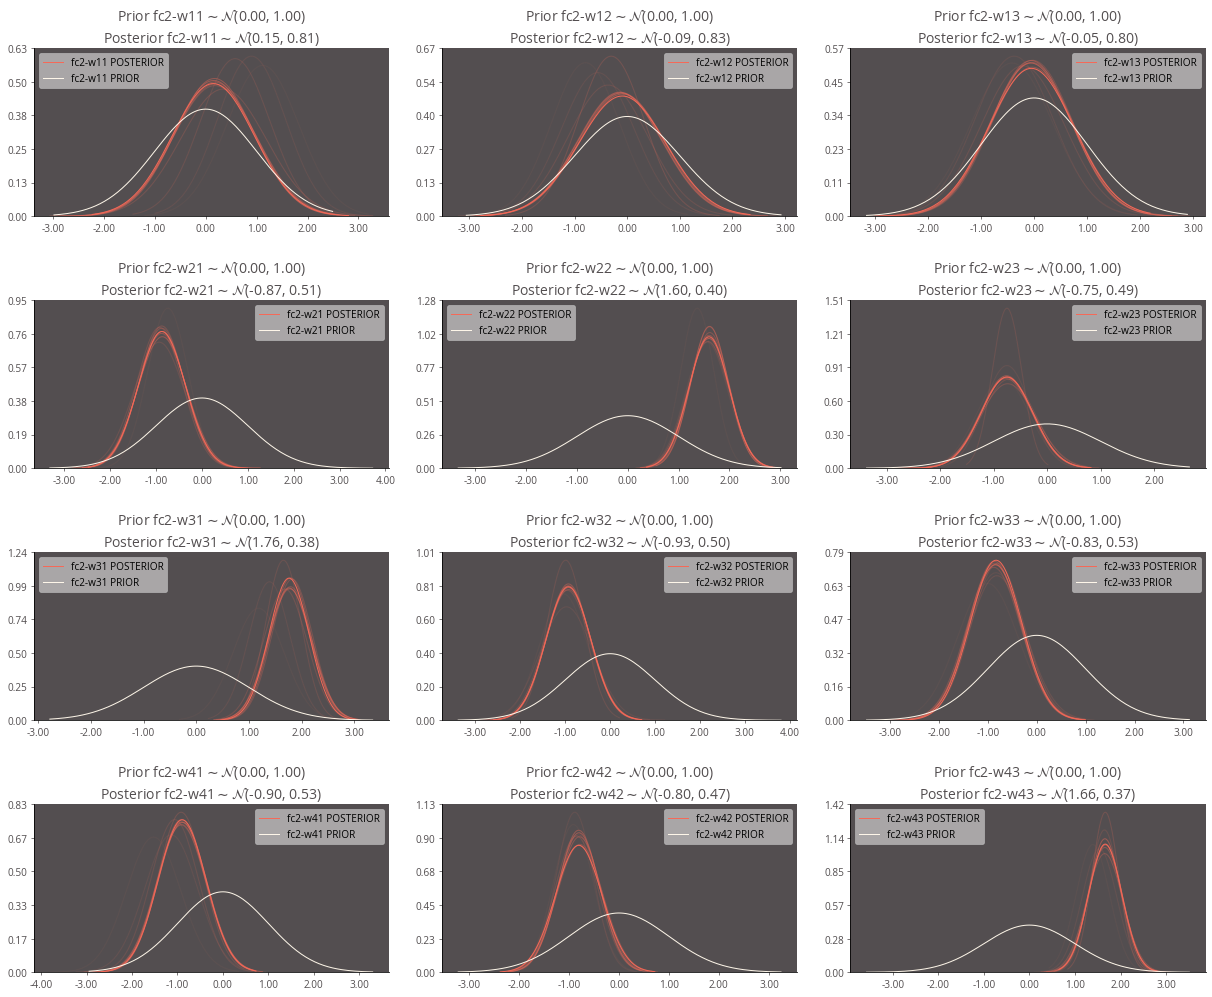

In [ ]:
# FC2 weights

fig, ax = plt.subplots(4, 3, figsize=(21, 17), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = bnn_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(bnn_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = 0, 1
        prior_value = None

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

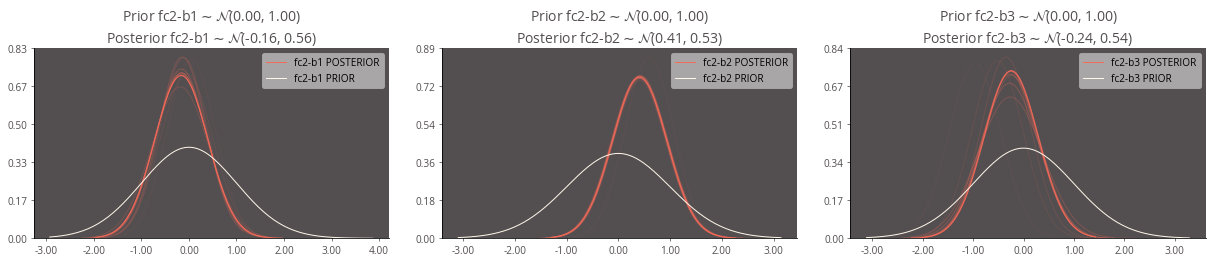

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.5), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = bnn_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(bnn_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = 0, 1
    prior_value = None

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

### **Check DNN with weights sampled from the posterior distribution**

In [ ]:
def get_labels(data):
    fc1_weight = bnn_params_store['_fc1w_loc'].T
    fc1_bias = bnn_params_store['_fc1b_loc'].T

    fc2_weight = bnn_params_store['_fc2w_loc'].T
    fc2_bias = bnn_params_store['_fc2b_loc'].T

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    return labels

Accuracy 0.99


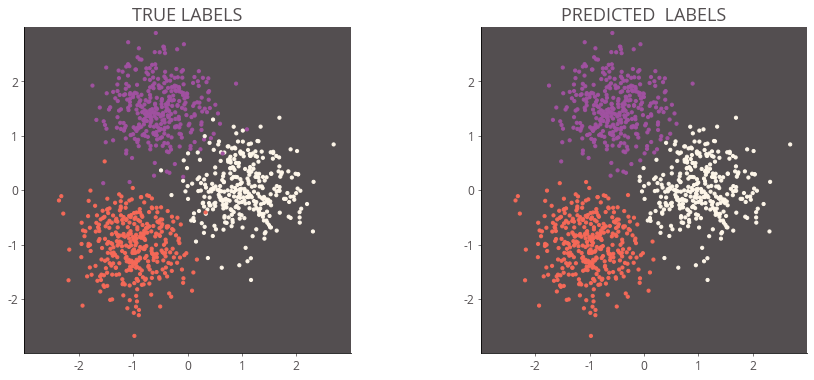

In [ ]:
predictions = get_labels(train_data)
acc = predictions.eq(train_labels.view_as(predictions)).float()
print('Accuracy {:.2f}'.format(acc.mean().item()))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], train_data.numpy(), train_labels.numpy().astype(int), 'true labels')
visualize_multiclass_data(ax[1], train_data.numpy(), predictions.numpy().astype(int), 'predicted  labels')

# **Sanity Check 1**



Data labeled using the posterior distributions of the Bayesian network for weights and biases

> $\mu_{_{SC}} = \mu _{BNN_{posterior}}$  
> $\sigma_{_{SC}} = \sigma _{BNN_{posterior}}$  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Function to label data for sanity check

def generate_labels(data):
    w1_loc = bnn_params_store['_fc1w_loc'].T.detach()
    w1_scale = torch.abs(bnn_params_store['_fc1w_scale']).T.detach()
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight  = []
    for _ in range(64):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight).mean(dim=0)

    b1_loc = bnn_params_store['_fc1b_loc'].T.detach()
    b1_scale = torch.abs(bnn_params_store['_fc1b_scale']).T.detach()
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(64):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias).mean(dim=0)
    
    w2_loc = bnn_params_store['_fc2w_loc'].T.detach()
    w2_scale = torch.abs(bnn_params_store['_fc2w_scale']).T.detach()
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(64):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight).mean(dim=0)

    b2_loc = bnn_params_store['_fc2b_loc'].T.detach()
    b2_scale = torch.abs(bnn_params_store['_fc2b_scale']).T.detach()
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(64):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias).mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[ 0.1086,  1.8648, -1.4298, -0.7932],
        [-0.1782, -0.3468, -1.7371,  1.8957]])
fc1_bias = 
 tensor([-0.7610,  0.6509,  0.1452, -0.0109])
fc2_weight = 
 tensor([[ 0.1538, -0.0938,  0.0678],
        [-0.8621,  1.5630, -0.7644],
        [ 1.8033, -0.9654, -0.8838],
        [-0.9171, -0.8135,  1.6698]])
fc2_bias = 
 tensor([-0.1577,  0.4615, -0.2759])



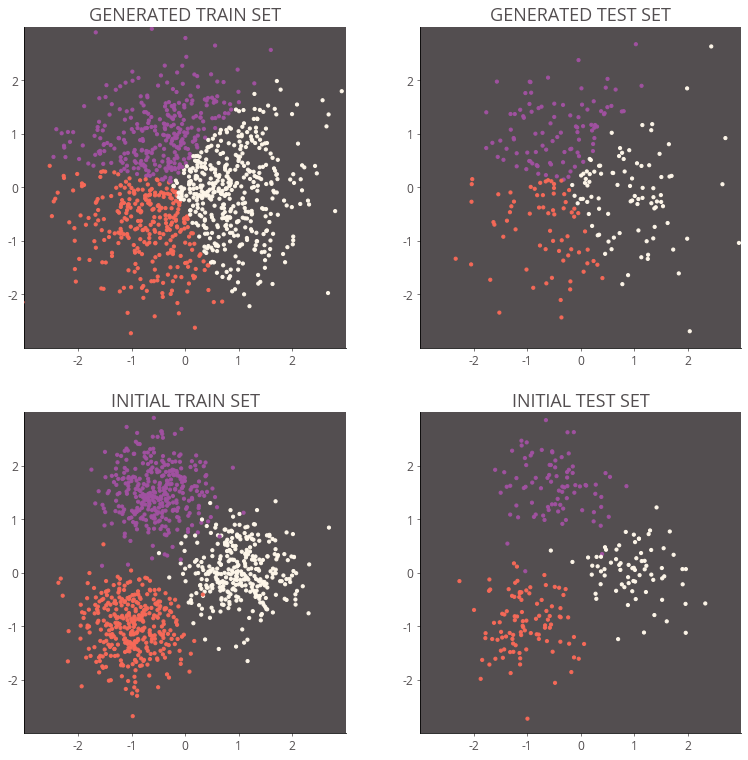

In [ ]:
# Generate train and test data for sanity check

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)
print('fc1_weight = \n', sc_fc1_weight)
print('fc1_bias = \n', sc_fc1_bias)
print('fc2_weight = \n', sc_fc2_weight)
print('fc2_bias = \n', sc_fc2_bias)
print()

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]

fig, ax = plt.subplots(2, 2, figsize=(13, 13))
visualize_multiclass_data(ax[0, 0], sc_train_data, sc_train_labels, 'generated train set')
visualize_multiclass_data(ax[0, 1], sc_test_data, sc_test_labels, 'generated test set')
visualize_multiclass_data(ax[1, 0], train_data, train_labels.int(), 'initial train set')
visualize_multiclass_data(ax[1, 1], test_data, test_labels.int(), 'initial test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        w1_loc = bnn_params_store['_fc1w_loc']
        w1_scale = bnn_params_store['_fc1w_scale']
        _fc1w_prior = dist.Normal(loc=w1_loc,
                                  scale=torch.abs(w1_scale))
        
        
        b1_loc = bnn_params_store['_fc1b_loc']
        b1_scale = bnn_params_store['_fc1b_scale']
        _fc1b_prior = dist.Normal(loc=b1_loc,
                                  scale=torch.abs(b1_scale))
        

        w2_loc = bnn_params_store['_fc2w_loc']
        w2_scale = bnn_params_store['_fc2w_scale']
        _fc2w_prior = dist.Normal(loc=w2_loc,
                                  scale=torch.abs(w2_scale))
        
        b2_loc = bnn_params_store['_fc2b_loc']
        b2_scale = bnn_params_store['_fc2b_scale']
        _fc2b_prior = dist.Normal(loc=b2_loc,
                                  scale=torch.abs(b2_scale))
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

sc_model_bdnn = DNN(2, 4, 3)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.Adam({'lr': .001})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    
    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)
    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.5032125   |   acc: 0.1513672
   BNN loss:  537.2649185   |   acc: 0.3720703

EPOCH 100
   DNN loss:    0.3508139   |   acc: 0.9423828
   BNN loss:  291.4572224   |   acc: 0.6777344

EPOCH 200
   DNN loss:    0.1686993   |   acc: 0.9785156
   BNN loss:  199.5613766   |   acc: 0.8496094

EPOCH 300
   DNN loss:    0.1354689   |   acc: 0.9892578
   BNN loss:  154.9300941   |   acc: 0.9052734

EPOCH 400
   DNN loss:    0.1244084   |   acc: 0.9921875
   BNN loss:  118.9338664   |   acc: 0.9248047

EPOCH 500
   DNN loss:    0.1199388   |   acc: 0.9941406
   BNN loss:   89.6344015   |   acc: 0.9267578

EPOCH 600
   DNN loss:    0.1175618   |   acc: 0.9941406
   BNN loss:   54.4765409   |   acc: 0.9433594

EPOCH 700
   DNN loss:    0.1161933   |   acc: 0.9941406
   BNN loss:   40.1771184   |   acc: 0.9697266

EPOCH 800
   DNN loss:    0.1153317   |   acc: 0.9941406
   BNN loss:   29.6384955   |   acc: 0.9736328

EPOCH 900
   DNN loss:    0.1147954   |   acc: 0.993164

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

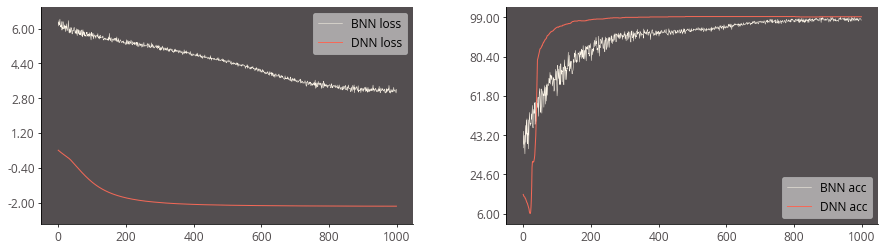

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        70
           1       1.00      1.00      1.00        91
           2       0.99      1.00      0.99        95

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        70
           1       1.00      0.99      0.99        91
           2       0.98      1.00      0.99        95

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



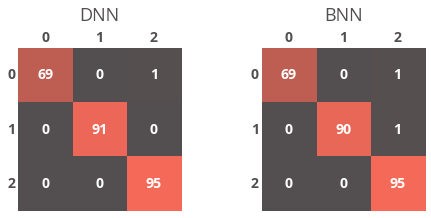

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

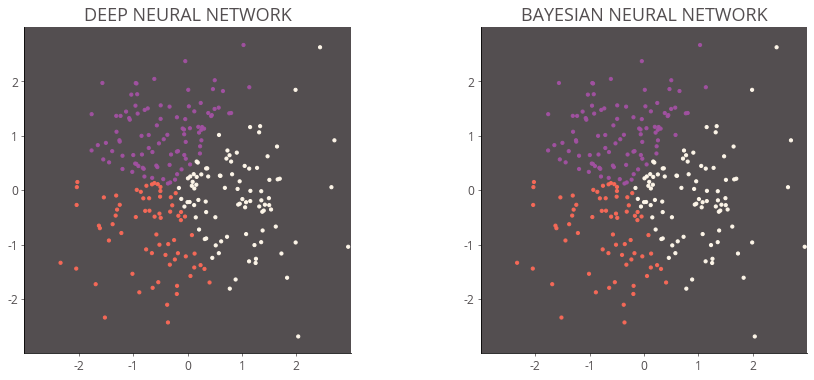

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

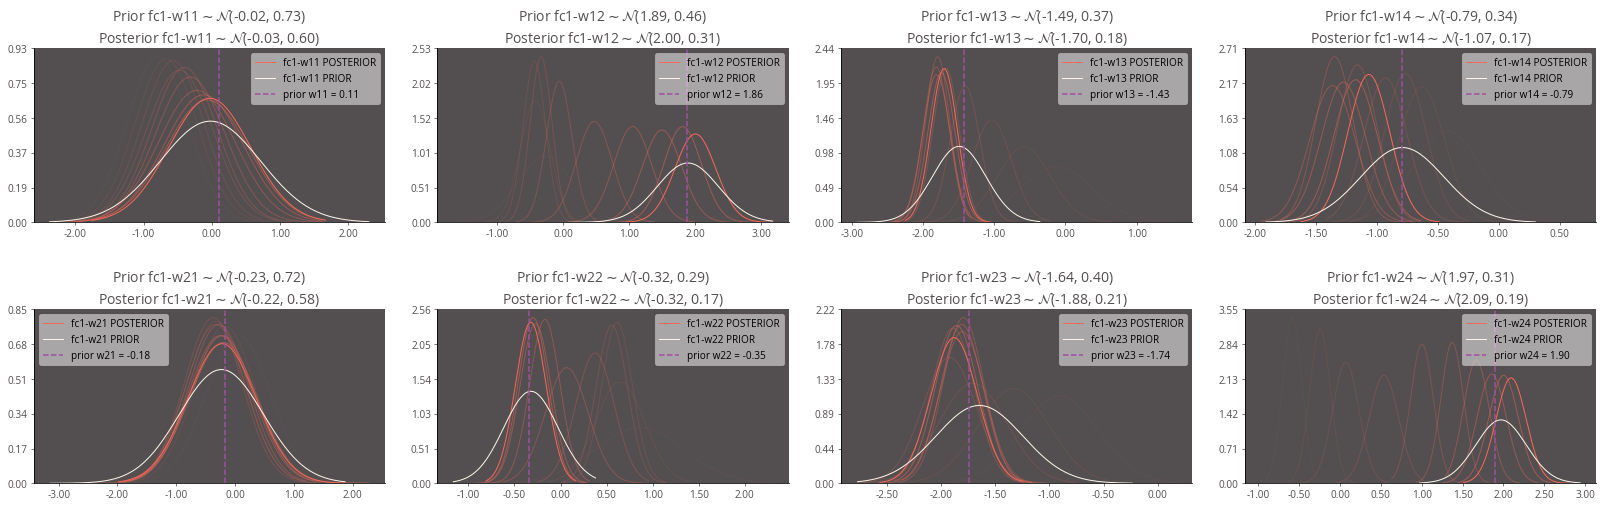

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

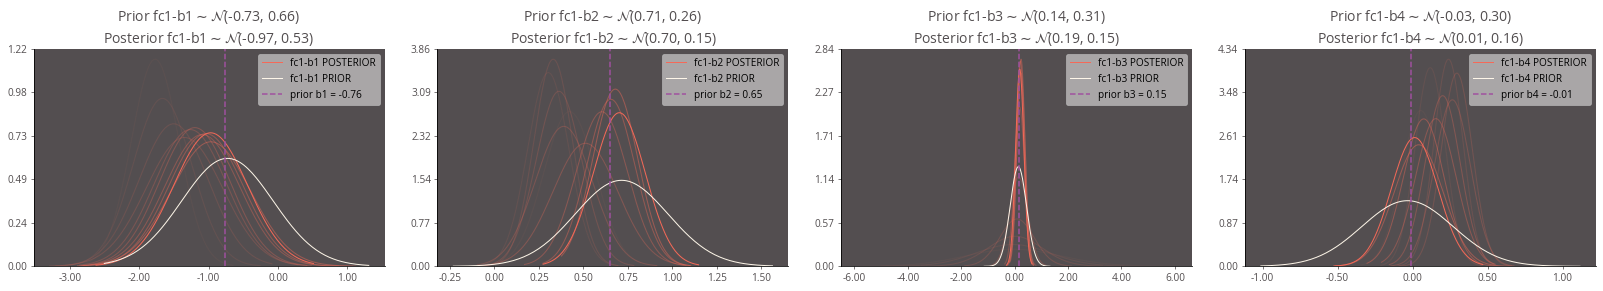

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]

    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

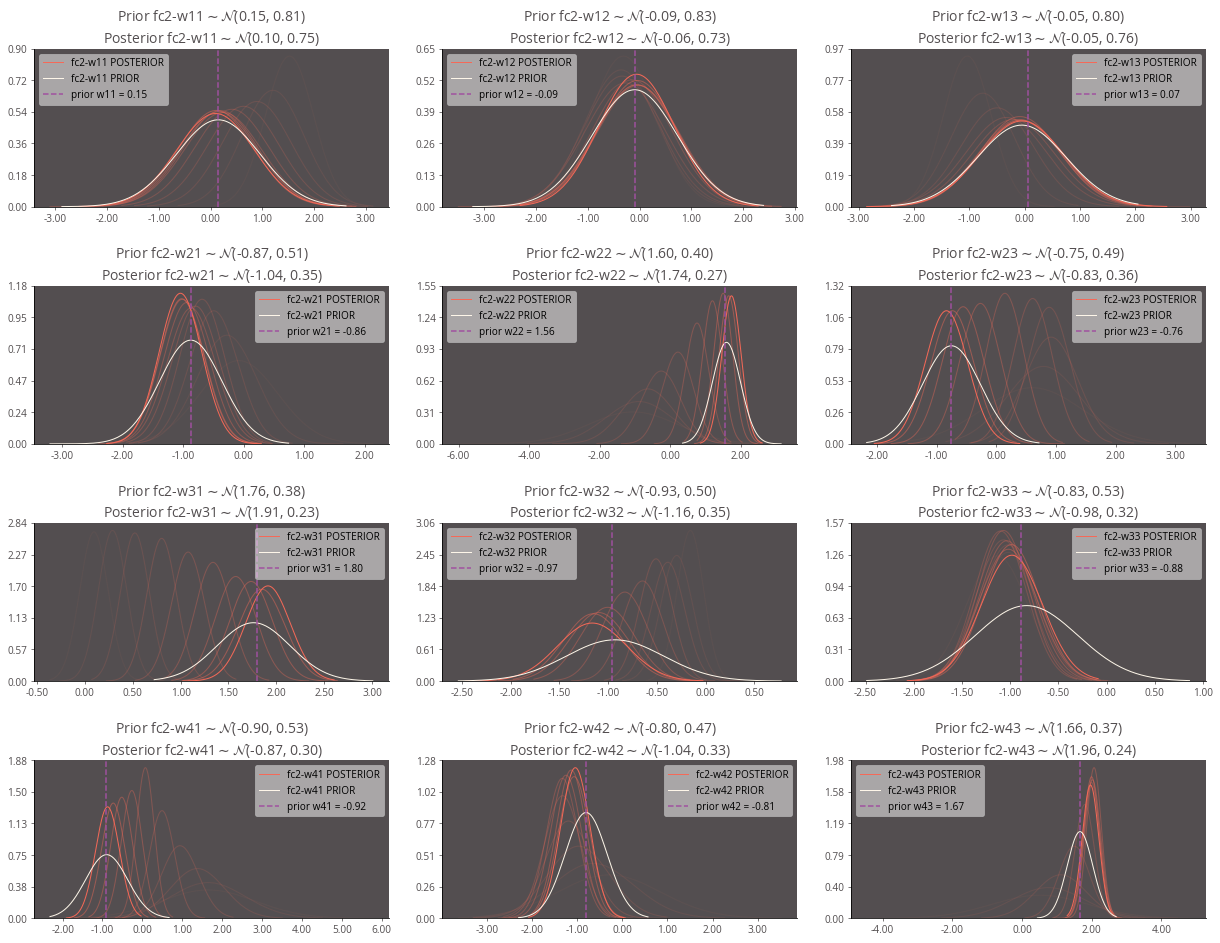

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 3, figsize=(21, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

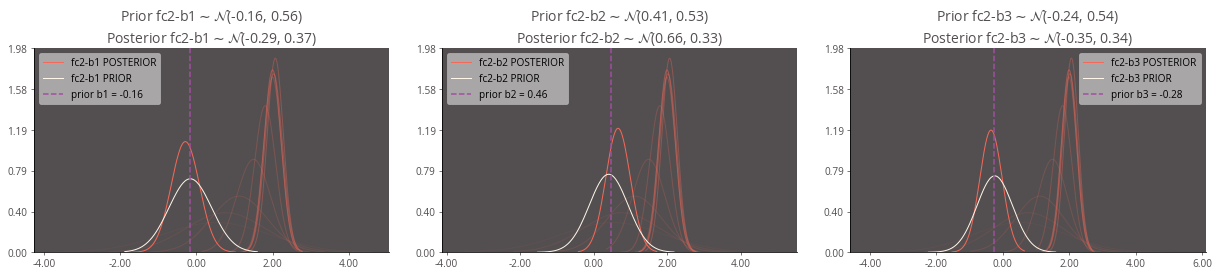

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]

    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    display_posterior_pdf(ax[col], param_name, loc_post, scale_post,
                          prior_value, loc_prior, scale_prior, 
                          inter_loc, inter_scale)

# **Sanity Check 2**


Data labeled using random integer initialization in range $-1 .. 1$ for weights and zero biases

> $w = \overline{-1, 1}$  
> $b = 0$


In [ ]:
# Function to label data for sanity check

def generate_labels(data):
    fc1_weight = torch.randint(-1, 2, (4, 2)).float().T
    fc1_bias = torch.zeros(4)
    fc2_weight = torch.randint(-1, 2, (3, 4)).float().T
    fc2_bias = torch.zeros(3)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    return fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-1.,  1., -1.,  0.],
        [-1.,  1., -1.,  1.]])

fc1_bias = 
 tensor([0., 0., 0., 0.])

fc2_weight = 
 tensor([[-1., -1., -1.],
        [ 0., -1.,  1.],
        [-1.,  0., -1.],
        [ 1.,  0., -1.]])

fc2_bias = 
 tensor([0., 0., 0.])


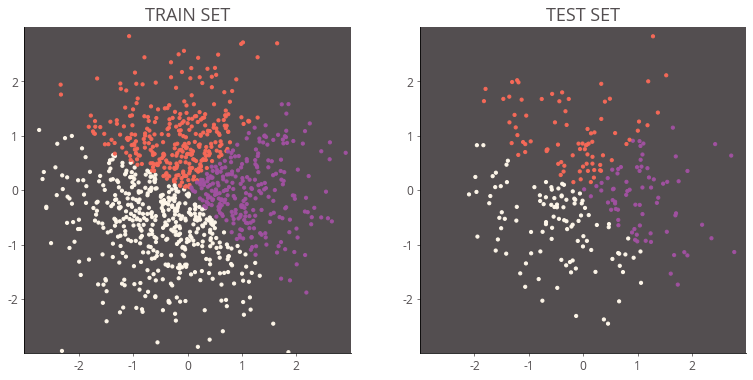

In [ ]:
# Generate train and test data for sanity check

sc_data = torch.randn(1280, 2)
sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels =\
 generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_multiclass_data(ax[0], sc_train_data, sc_train_labels, 'train set')
visualize_multiclass_data(ax[1], sc_test_data, sc_test_labels, 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_fc1_weight.T,
                                  scale=torch.ones(self.hid_size, self.in_size))
        _fc1b_prior = dist.Normal(loc=sc_fc1_bias.T,
                                  scale=torch.ones(self.hid_size))
        
        _fc2w_prior = dist.Normal(loc=sc_fc2_weight.T,
                                  scale=torch.ones(self.out_size, self.hid_size))
        _fc2b_prior = dist.Normal(loc=sc_fc2_bias.T,
                                  scale=torch.ones(self.out_size))
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

sc_model_bdnn = DNN(2, 4, 3)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.Adam({'lr': .005})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    
    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.2290871   |   acc: 0.3066406
   BNN loss:  397.9318185   |   acc: 0.2617188

EPOCH 100
   DNN loss:    0.4384797   |   acc: 0.8720703
   BNN loss:   84.3424110   |   acc: 0.9003906

EPOCH 200
   DNN loss:    0.2344549   |   acc: 0.9785156
   BNN loss:   51.4120601   |   acc: 0.9609375

EPOCH 300
   DNN loss:    0.1502734   |   acc: 0.9873047
   BNN loss:   48.8449246   |   acc: 0.9687500

EPOCH 400
   DNN loss:    0.1357335   |   acc: 0.9853516
   BNN loss:   47.6905159   |   acc: 0.9746094

EPOCH 500
   DNN loss:    0.1309660   |   acc: 0.9863281
   BNN loss:   51.7604498   |   acc: 0.9814453

EPOCH 600
   DNN loss:    0.1281863   |   acc: 0.9863281
   BNN loss:   42.1223318   |   acc: 0.9804688

EPOCH 700
   DNN loss:    0.1266407   |   acc: 0.9853516
   BNN loss:   44.4191694   |   acc: 0.9824219

EPOCH 800
   DNN loss:    0.1258523   |   acc: 0.9824219
   BNN loss:   44.6753627   |   acc: 0.9794922

EPOCH 900
   DNN loss:    0.1255108   |   acc: 0.982421

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

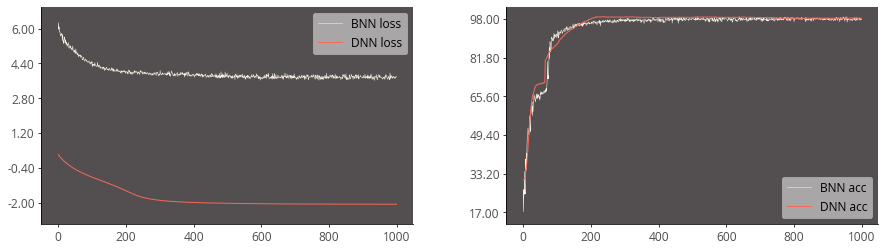

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       0.98      0.97      0.98       105
           2       0.96      0.97      0.97        72

    accuracy                           0.98       256
   macro avg       0.98      0.98      0.98       256
weighted avg       0.98      0.98      0.98       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        79
           1       0.97      0.99      0.98       105
           2       0.94      0.94      0.94        72

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



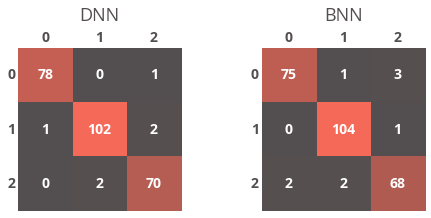

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

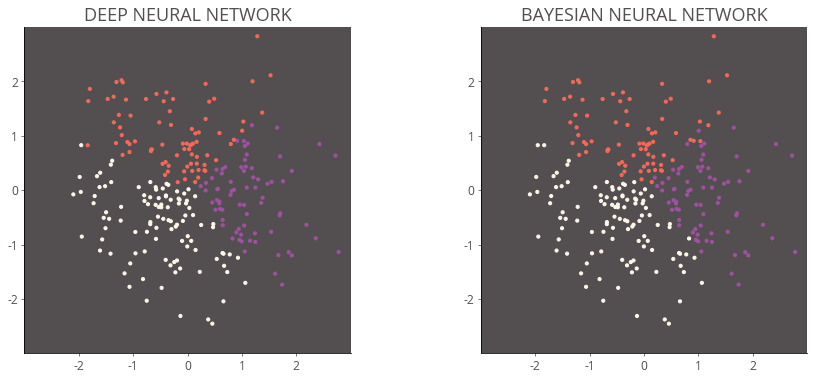

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

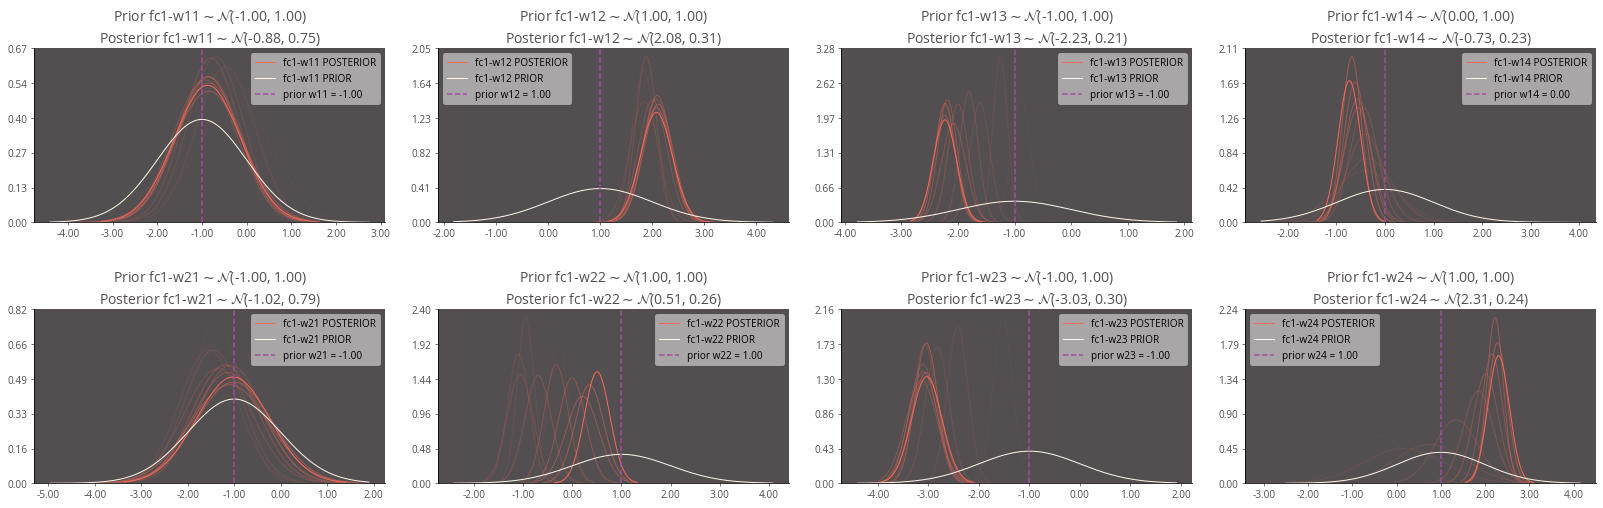

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):
        
        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = sc_fc1_weight[row, col], 1
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

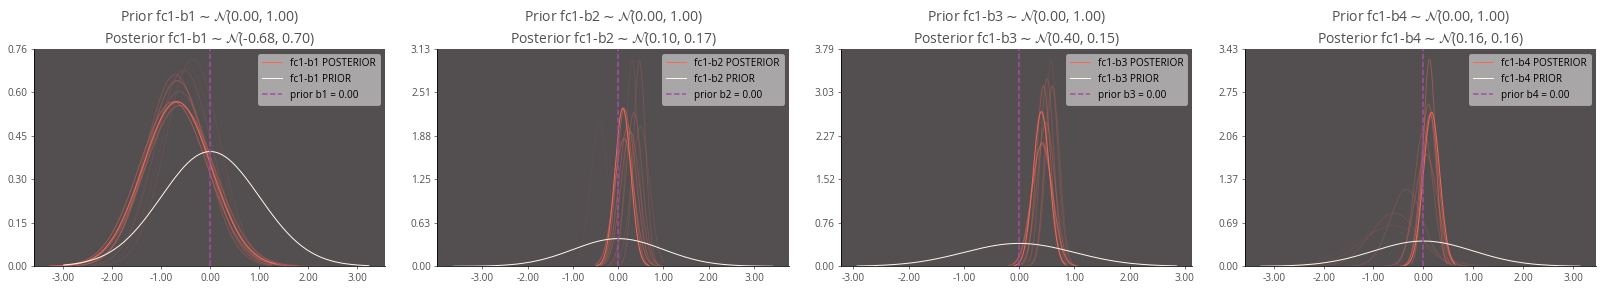

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):

    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = sc_fc1_bias[col], 1
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

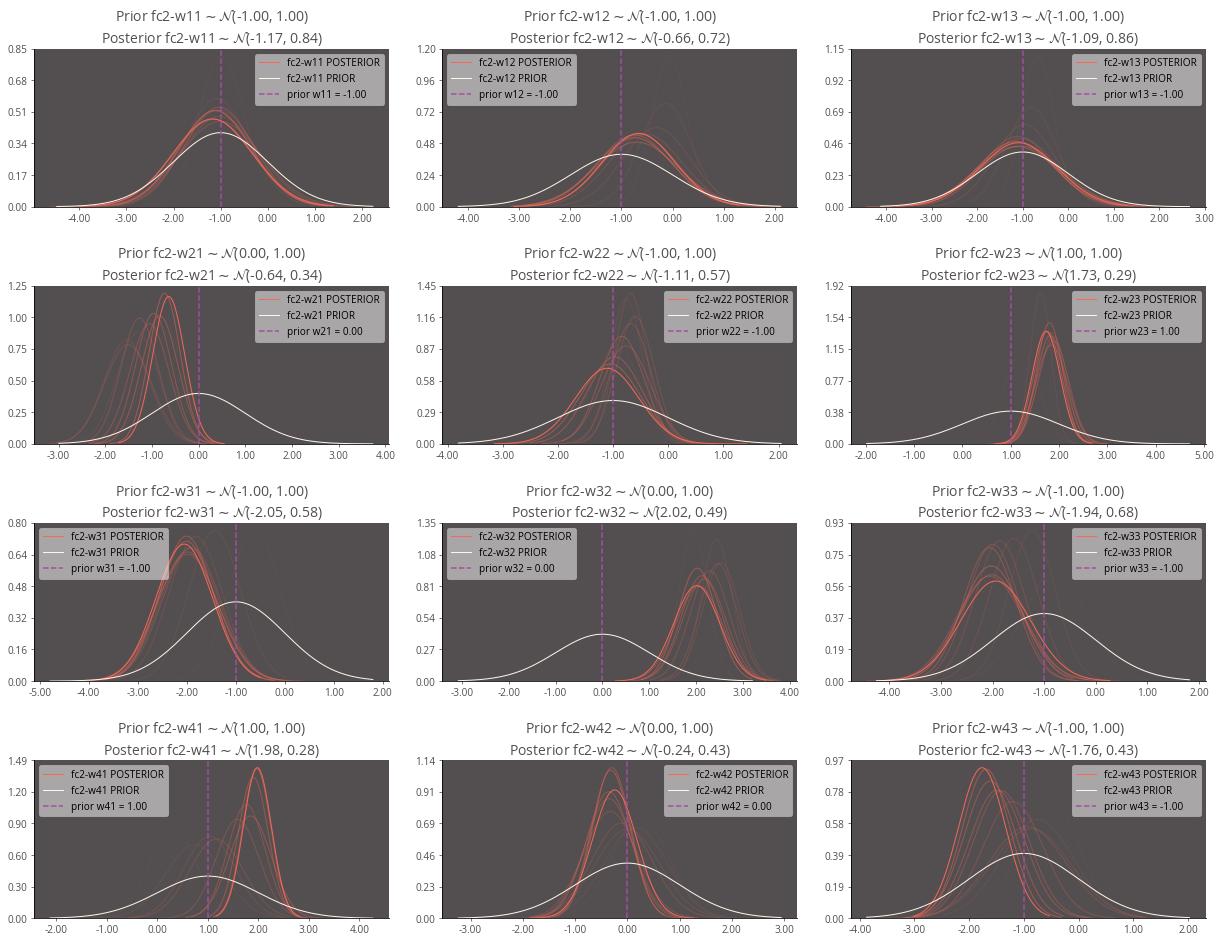

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 3, figsize=(21, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        loc_prior, scale_prior = sc_fc2_weight[row, col], 1
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

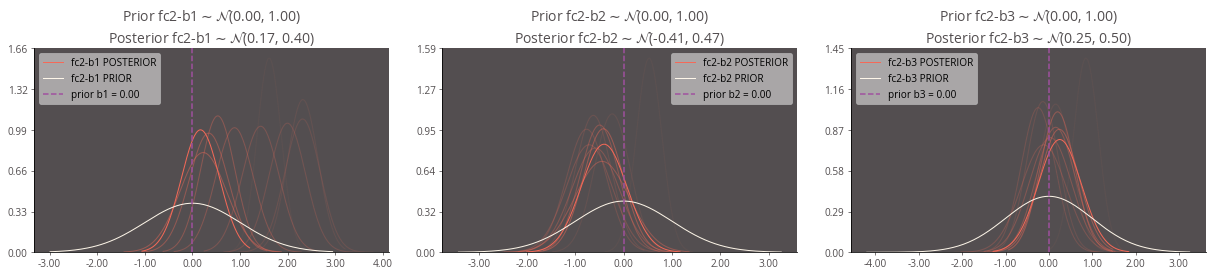

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
    loc_prior, scale_prior = sc_fc2_bias[col], 1
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 3**


Data labeled using random initialization for the weights and biases distributions parameters (average of repeated sampling)

> $\mu_{_{SC}} \sim \mathcal{N}(0, 1)$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1)$  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    w1_loc = torch.randn(4, 2).float().T
    w1_scale = torch.abs(torch.randn(4, 2).float().T)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(64):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float()
    b1_scale = torch.abs(torch.randn(4).float())
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(64):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(3, 4).float().T
    w2_scale = torch.abs(torch.randn(3, 4).float().T)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(64):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(3).float()
    b2_scale = torch.abs(torch.randn(3).float())
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(64):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-0.2237, -0.6804,  2.7112,  0.6412],
        [ 0.2799, -1.6012, -0.5492, -1.1819]])

fc1_bias = 
 tensor([ 0.3117,  0.8652, -0.6337,  1.3889])

fc2_weight = 
 tensor([[ 0.8080, -1.0155, -0.1598],
        [ 0.4233,  0.0239, -1.2547],
        [ 0.2561,  0.9541,  2.0000],
        [ 0.2392,  0.3715, -1.8593]])

fc2_bias = 
 tensor([ 0.0257, -0.2431,  1.1981])


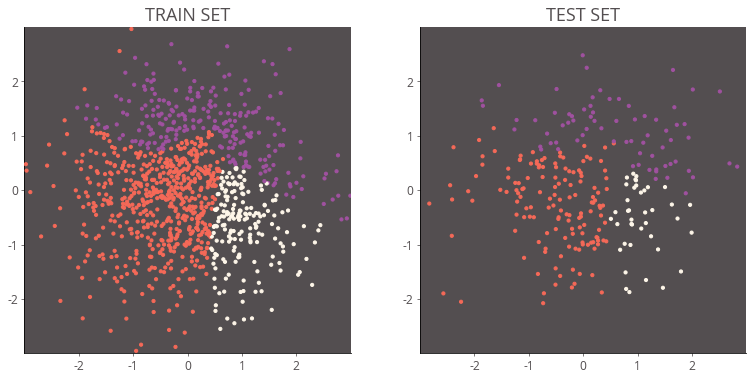

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_multiclass_data(ax[0], sc_train_data, sc_train_labels, 'train set')
visualize_multiclass_data(ax[1], sc_test_data, sc_test_labels, 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

sc_model_bdnn = DNN(2, 4, 3)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.Adam({'lr': .01})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    
    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.1919217   |   acc: 0.1777344
   BNN loss: 1341.2860011   |   acc: 0.2587891

EPOCH 100
   DNN loss:    0.4426306   |   acc: 0.8496094
   BNN loss:   62.5093553   |   acc: 0.9218750

EPOCH 200
   DNN loss:    0.2556388   |   acc: 0.9101562
   BNN loss:   56.0702501   |   acc: 0.9541016

EPOCH 300
   DNN loss:    0.2099661   |   acc: 0.9316406
   BNN loss:   52.0253814   |   acc: 0.9404297

EPOCH 400
   DNN loss:    0.1943159   |   acc: 0.9404297
   BNN loss:   50.0705702   |   acc: 0.9462891

EPOCH 500
   DNN loss:    0.1881207   |   acc: 0.9453125
   BNN loss:   48.6152243   |   acc: 0.9462891

EPOCH 600
   DNN loss:    0.1852510   |   acc: 0.9462891
   BNN loss:   52.6612187   |   acc: 0.9482422

EPOCH 700
   DNN loss:    0.1838413   |   acc: 0.9472656
   BNN loss:   54.2477118   |   acc: 0.9570312

EPOCH 800
   DNN loss:    0.1831453   |   acc: 0.9472656
   BNN loss:   48.1592482   |   acc: 0.9521484

EPOCH 900
   DNN loss:    0.1827761   |   acc: 0.947265

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

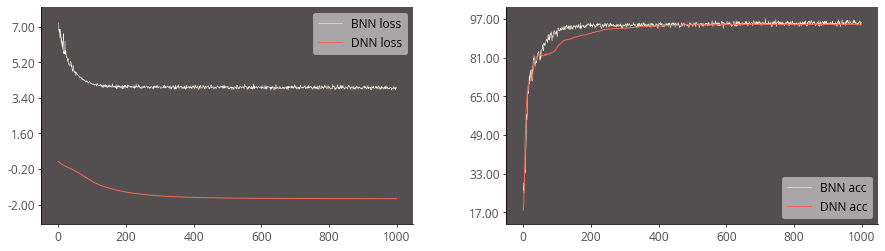

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       145
           1       1.00      0.97      0.99        40
           2       0.98      0.92      0.95        71

    accuracy                           0.97       256
   macro avg       0.98      0.96      0.97       256
weighted avg       0.97      0.97      0.97       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       145
           1       0.93      0.97      0.95        40
           2       0.97      0.90      0.93        71

    accuracy                           0.96       256
   macro avg       0.95      0.95      0.95       256
weighted avg       0.96      0.96      0.96       256



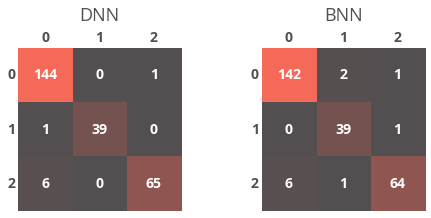

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

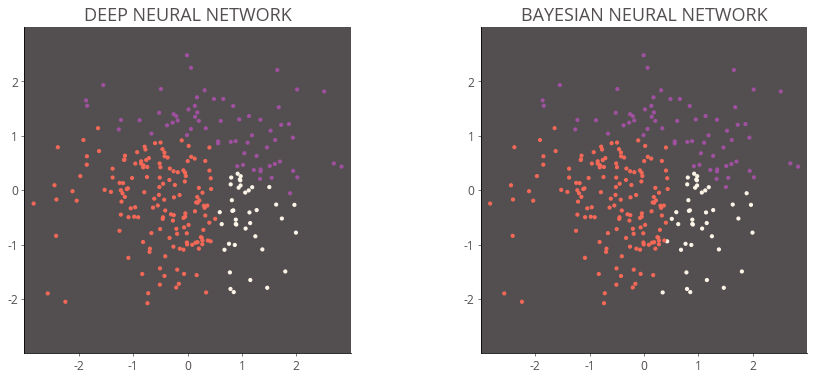

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

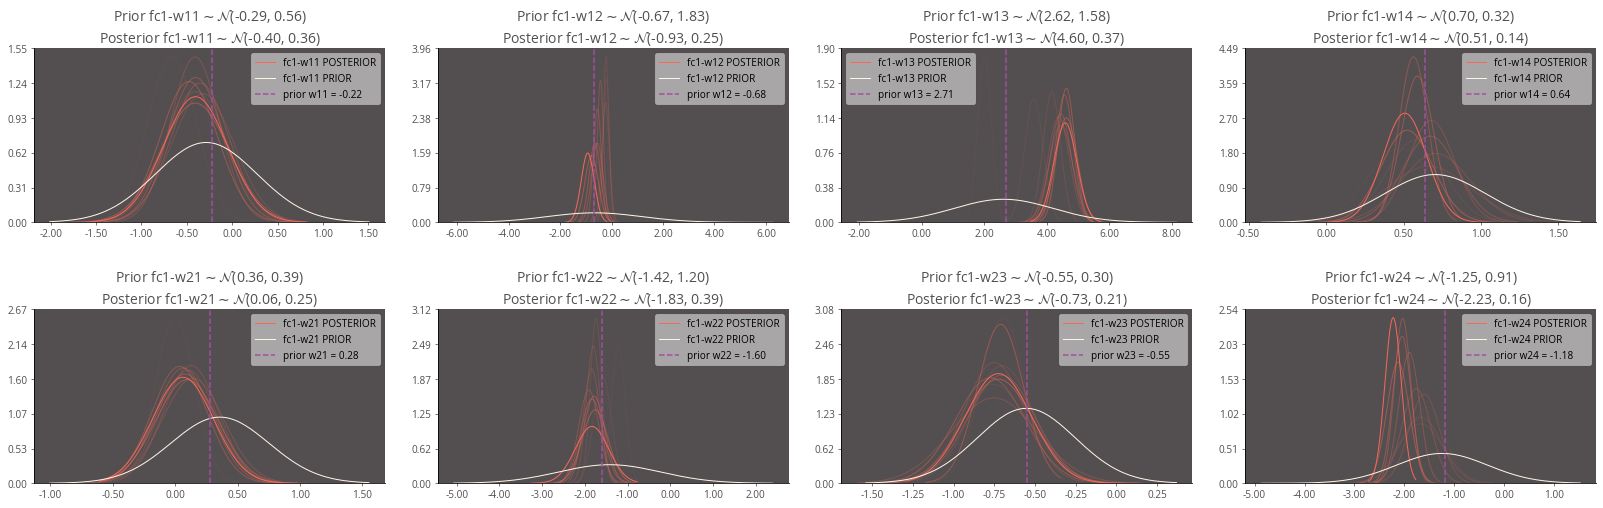

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

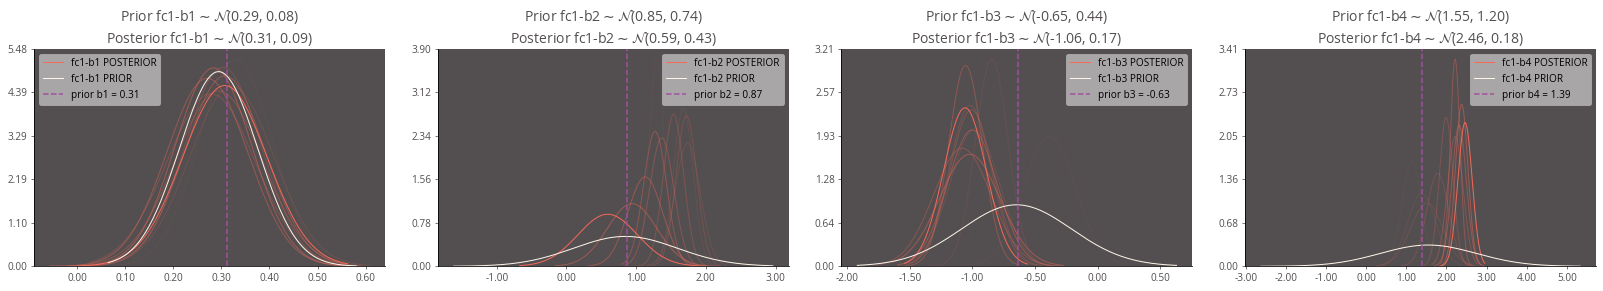

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

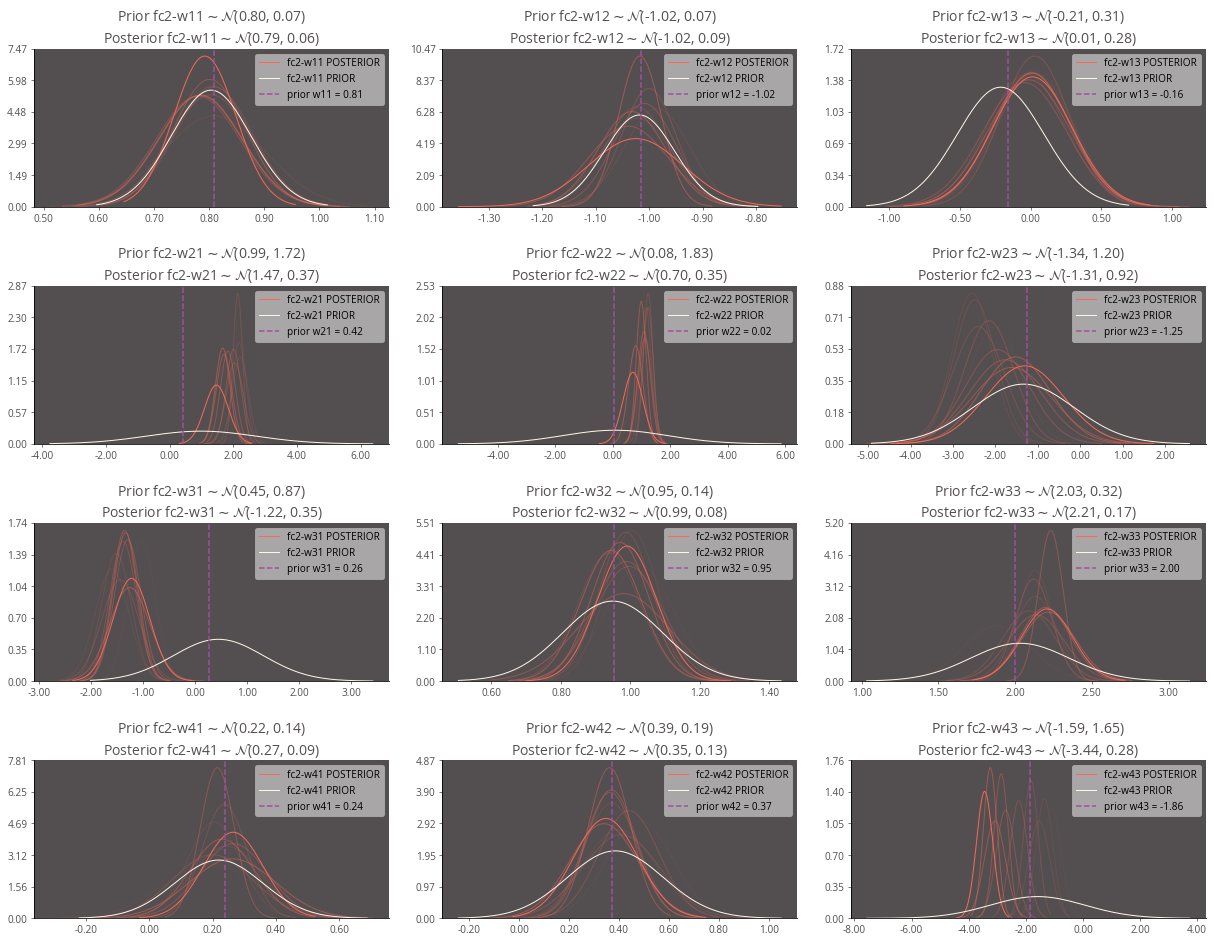

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 3, figsize=(21, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

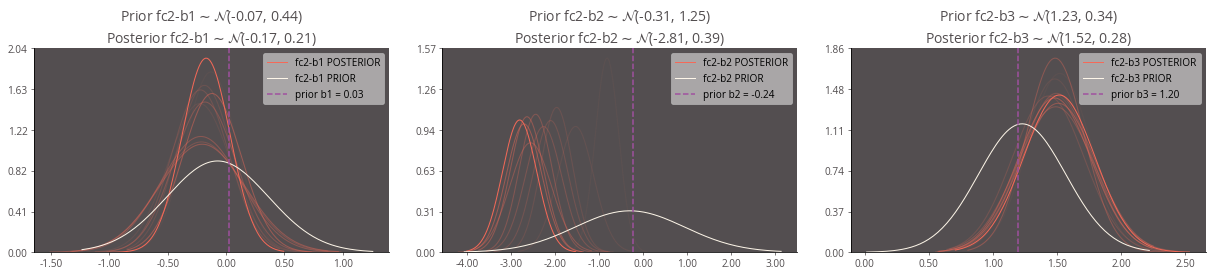

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 4**


Data labeled using random initialization for the weights and biases distributions parameters
> $\mu_{_{SC}} \sim \mathcal{N}(0, 1)$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1) $   
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    w1_loc = torch.randn(4, 2).float().T
    w1_scale = torch.abs(torch.randn(4, 2).float().T)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(1):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float()
    b1_scale = torch.abs(torch.randn(4).float())
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(1):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(3, 4).float().T
    w2_scale = torch.abs(torch.randn(3, 4).float().T)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(1):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(3).float()
    b2_scale = torch.abs(torch.randn(3).float())
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(1):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[ 1.0067,  1.0011,  1.2142,  0.0729],
        [ 2.0448,  0.5144, -0.2338,  0.9295]])

fc1_bias = 
 tensor([-1.2122, -0.6955,  0.0788,  0.8203])

fc2_weight = 
 tensor([[ 1.5258, -2.6265, -0.9005],
        [-0.2520, -2.4293,  0.0316],
        [ 0.8059, -0.4581,  1.9977],
        [ 0.1493,  1.0998, -0.3951]])

fc2_bias = 
 tensor([-0.5167,  1.7288,  2.4542])


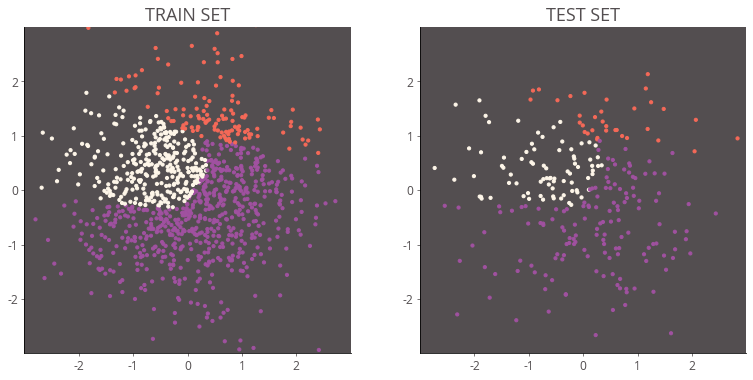

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_multiclass_data(ax[0], sc_train_data, sc_train_labels, 'train set')
visualize_multiclass_data(ax[1], sc_test_data, sc_test_labels, 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

sc_model_bdnn = DNN(2, 4, 3)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.Adam({'lr': .01})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    
    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)
    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.1227911   |   acc: 0.1513672
   BNN loss: 50930.9073434   |   acc: 0.4677734

EPOCH 100
   DNN loss:    0.4362666   |   acc: 0.8818359
   BNN loss:   87.6901778   |   acc: 0.8935547

EPOCH 200
   DNN loss:    0.2910842   |   acc: 0.9296875
   BNN loss:   52.8922563   |   acc: 0.9638672

EPOCH 300
   DNN loss:    0.2368813   |   acc: 0.9453125
   BNN loss:   53.5958663   |   acc: 0.9589844

EPOCH 400
   DNN loss:    0.2118021   |   acc: 0.9560547
   BNN loss:   49.7442053   |   acc: 0.9453125

EPOCH 500
   DNN loss:    0.1999918   |   acc: 0.9560547
   BNN loss:   54.2892729   |   acc: 0.9609375

EPOCH 600
   DNN loss:    0.1951241   |   acc: 0.9580078
   BNN loss:   51.3148582   |   acc: 0.9580078

EPOCH 700
   DNN loss:    0.1933824   |   acc: 0.9580078
   BNN loss:   49.7938667   |   acc: 0.9648438

EPOCH 800
   DNN loss:    0.1928634   |   acc: 0.9580078
   BNN loss:   51.7309327   |   acc: 0.9550781

EPOCH 900
   DNN loss:    0.1926188   |   acc: 0.95800

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

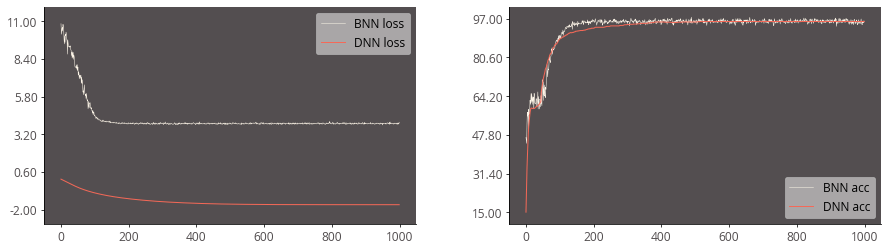

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        34
           1       0.97      0.94      0.95        79
           2       0.96      0.99      0.97       143

    accuracy                           0.96       256
   macro avg       0.97      0.95      0.96       256
weighted avg       0.97      0.96      0.96       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        34
           1       0.93      0.94      0.93        79
           2       0.97      0.99      0.98       143

    accuracy                           0.96       256
   macro avg       0.96      0.94      0.95       256
weighted avg       0.96      0.96      0.96       256



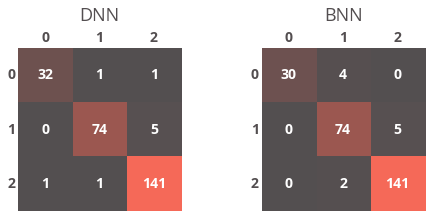

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

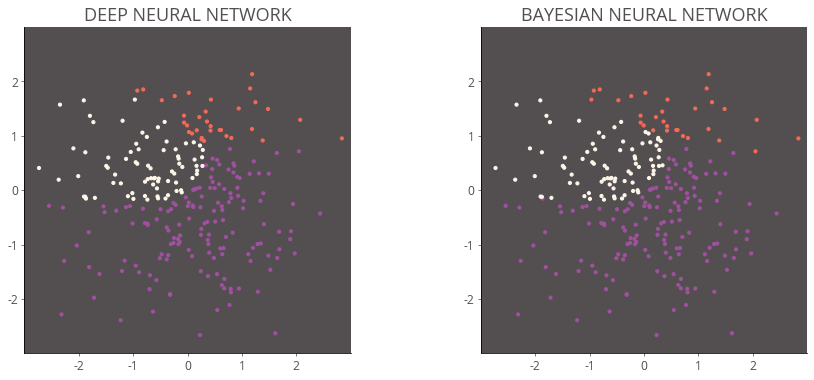

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

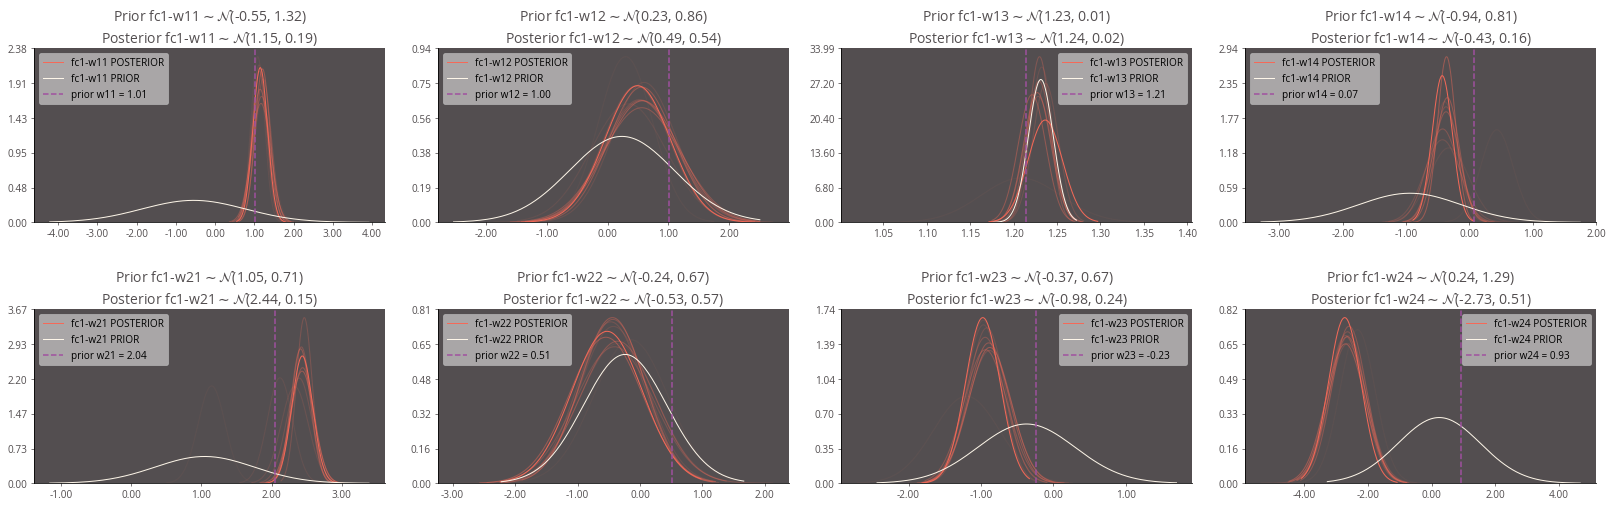

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

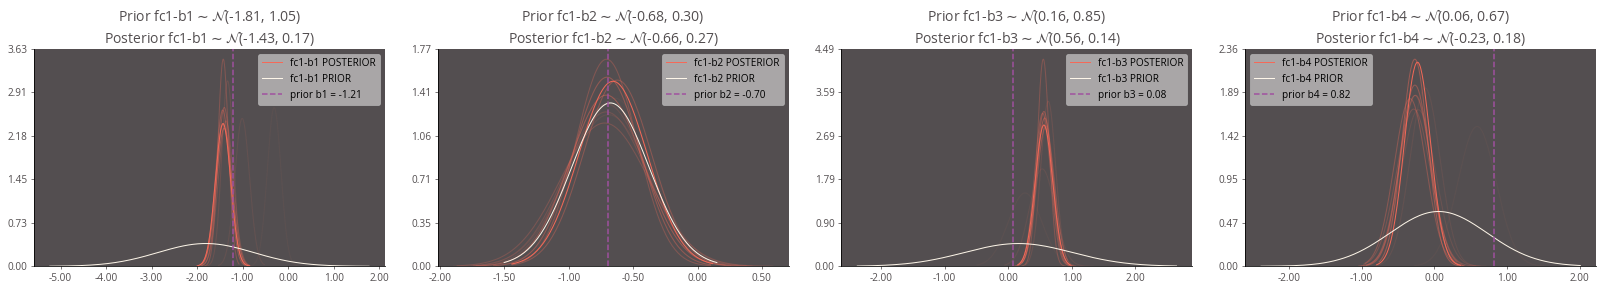

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

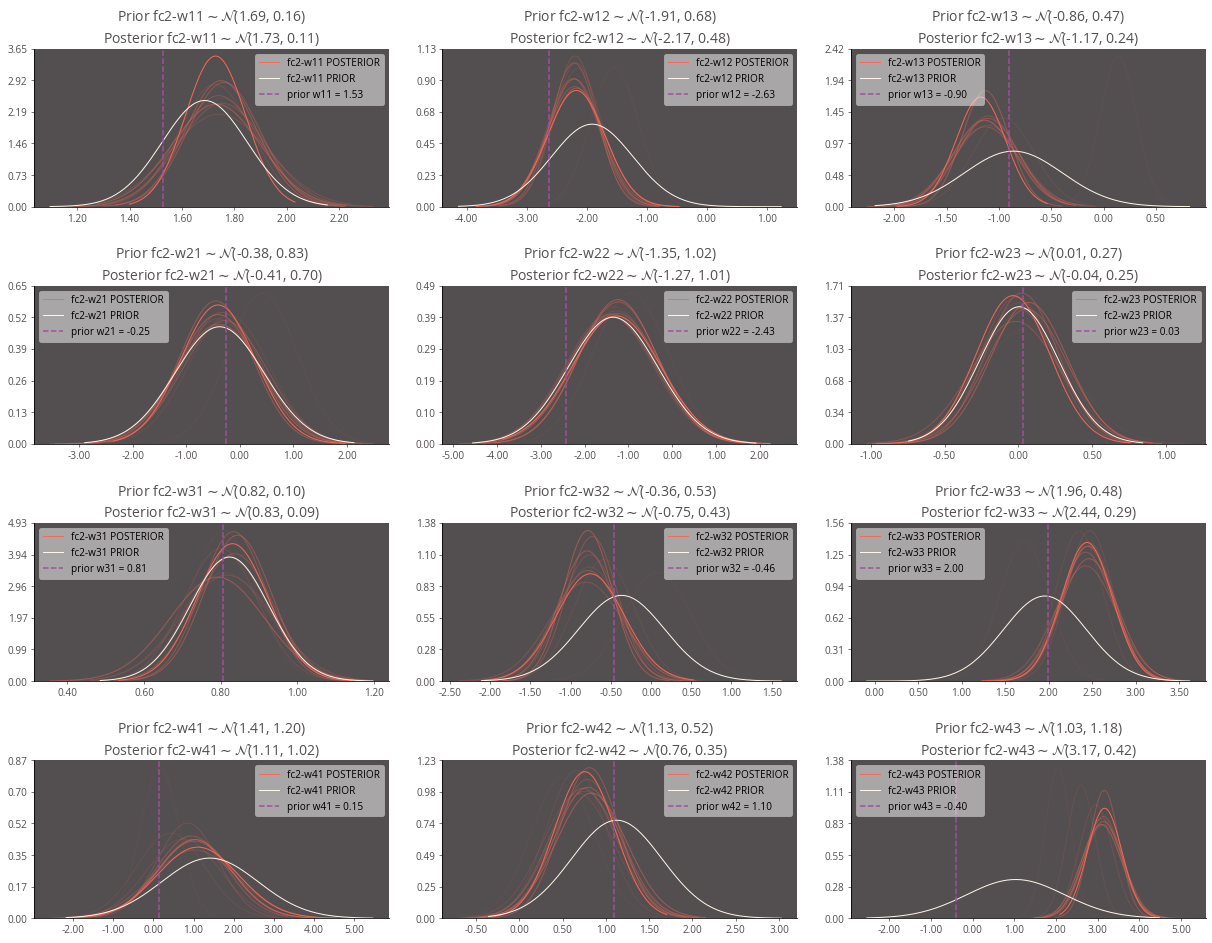

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 3, figsize=(21, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

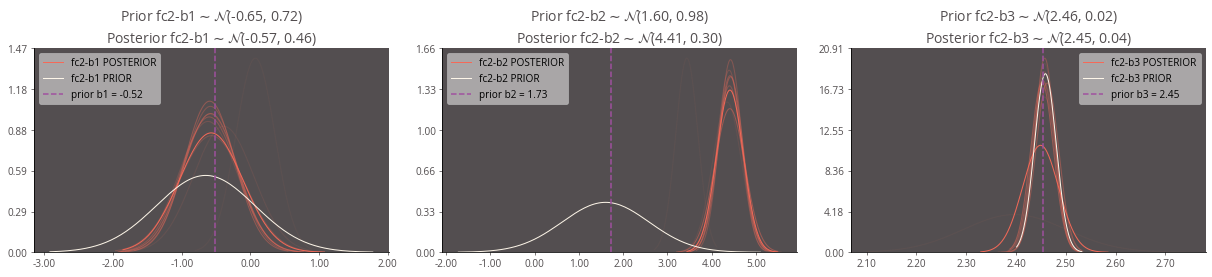

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 5**


Data labeled using random initialization for the weights and biases distributions parameters
> $\mu_{_{SC}} \sim \mathcal{N}(0, 1) \times c$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1) \times c$ ,  where $c \sim \mathcal{U}(0, 1)$  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    c = torch.rand(1)
    w1_loc = torch.randn(4, 2).float().T * c
    w1_scale = torch.abs(torch.randn(4, 2).float().T * c)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(1):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float() * c
    b1_scale = torch.abs(torch.randn(4).float() * c)
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(1):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(3, 4).float().T * c
    w2_scale = torch.abs(torch.randn(3, 4).float().T * c)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(1):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(3).float() * c
    b2_scale = torch.abs(torch.randn(3).float() * c)
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(1):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[-0.9742, -2.0066,  0.1199, -0.8938],
        [-1.8832,  2.2778, -0.2461, -0.0355]])

fc1_bias = 
 tensor([ 1.0472,  0.1404,  0.4162, -3.5141])

fc2_weight = 
 tensor([[-1.0398, -2.3122, -0.8303],
        [-1.1555, -0.0291,  0.4321],
        [ 1.1876,  1.2175, -0.3643],
        [ 0.4408, -0.4600, -0.3451]])

fc2_bias = 
 tensor([-0.5526,  0.9479, -1.4203])


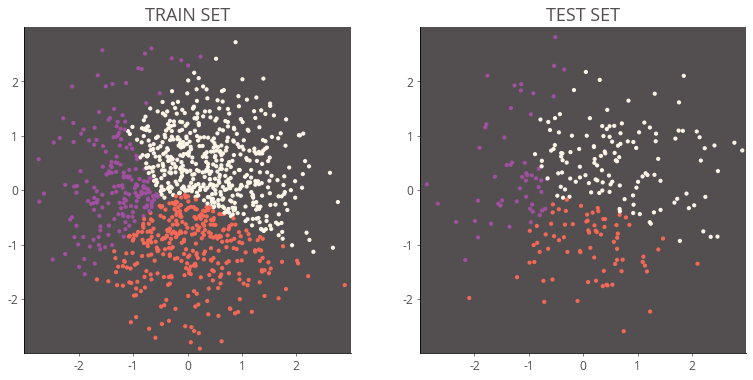

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_multiclass_data(ax[0], sc_train_data, sc_train_labels, 'train set')
visualize_multiclass_data(ax[1], sc_test_data, sc_test_labels, 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

sc_model_bdnn = DNN(2, 4, 3)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.Adam({'lr': .005})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    
    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.0749328   |   acc: 0.3203125
   BNN loss: 5435.8978580   |   acc: 0.5000000

EPOCH 100
   DNN loss:    0.3942168   |   acc: 0.9082031
   BNN loss:  165.0050355   |   acc: 0.8427734

EPOCH 200
   DNN loss:    0.2166138   |   acc: 0.9482422
   BNN loss:   65.9780291   |   acc: 0.9609375

EPOCH 300
   DNN loss:    0.1793357   |   acc: 0.9531250
   BNN loss:   56.8463155   |   acc: 0.9560547

EPOCH 400
   DNN loss:    0.1703149   |   acc: 0.9599609
   BNN loss:   50.9489452   |   acc: 0.9619141

EPOCH 500
   DNN loss:    0.1653895   |   acc: 0.9619141
   BNN loss:   55.3664778   |   acc: 0.9687500

EPOCH 600
   DNN loss:    0.1617833   |   acc: 0.9638672
   BNN loss:   56.1274176   |   acc: 0.9599609

EPOCH 700
   DNN loss:    0.1587621   |   acc: 0.9716797
   BNN loss:   49.9924563   |   acc: 0.9560547

EPOCH 800
   DNN loss:    0.1562210   |   acc: 0.9726562
   BNN loss:   55.4481132   |   acc: 0.9628906

EPOCH 900
   DNN loss:    0.1540821   |   acc: 0.973632

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

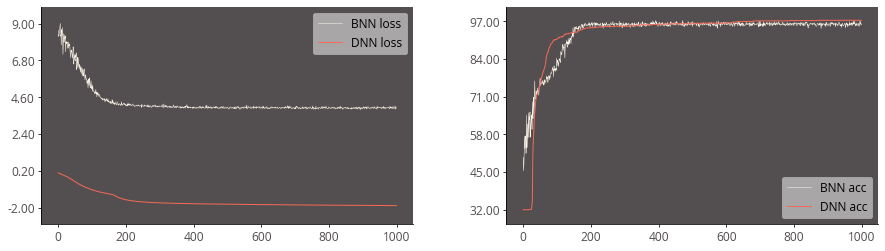

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        75
           1       0.95      0.99      0.97       128
           2       1.00      0.92      0.96        53

    accuracy                           0.97       256
   macro avg       0.98      0.96      0.97       256
weighted avg       0.97      0.97      0.97       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        75
           1       0.95      0.98      0.96       128
           2       1.00      0.87      0.93        53

    accuracy                           0.95       256
   macro avg       0.96      0.93      0.94       256
weighted avg       0.95      0.95      0.95       256



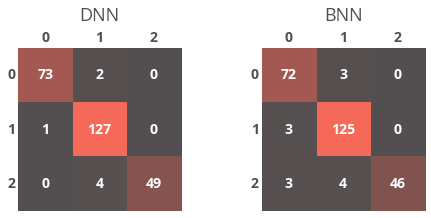

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

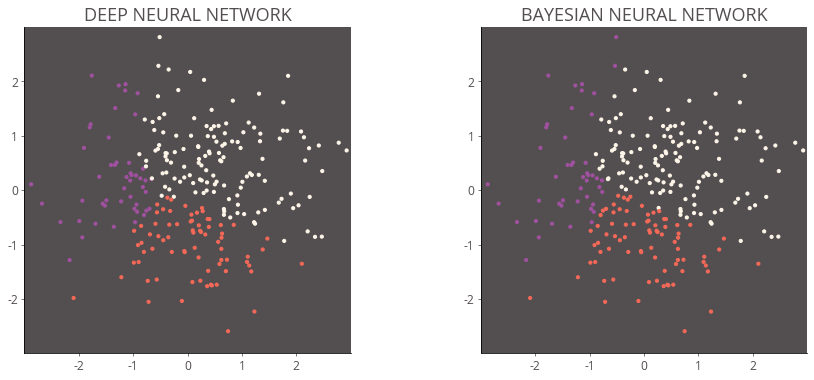

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

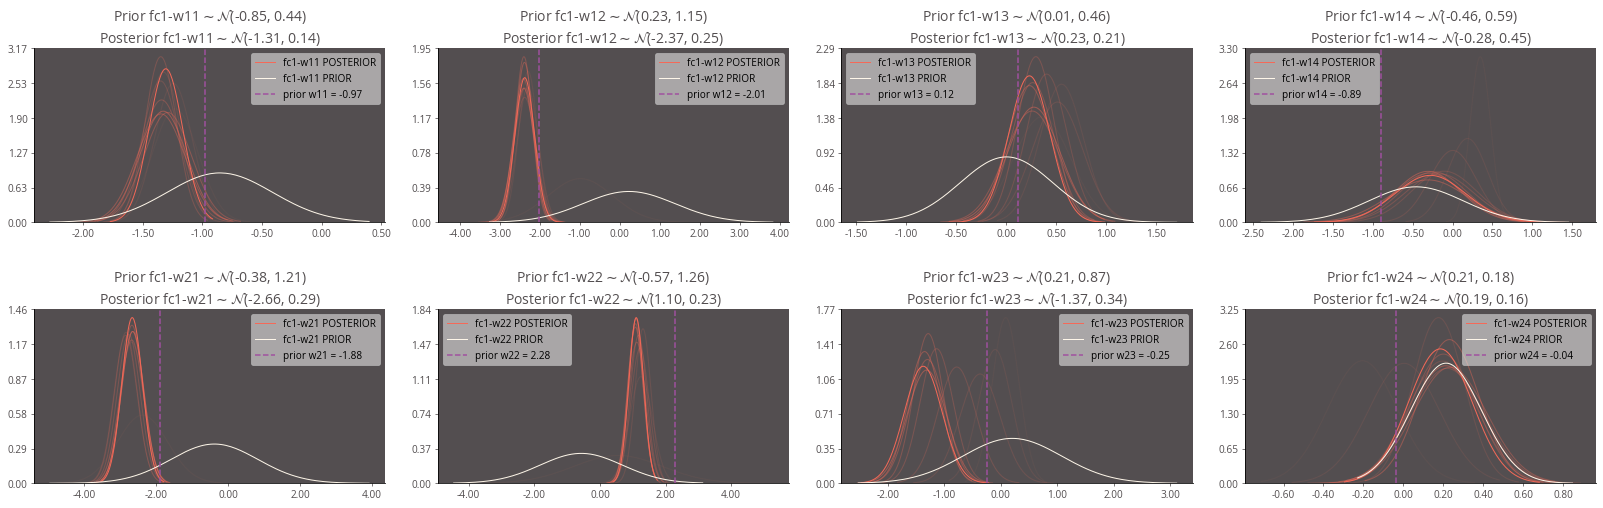

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

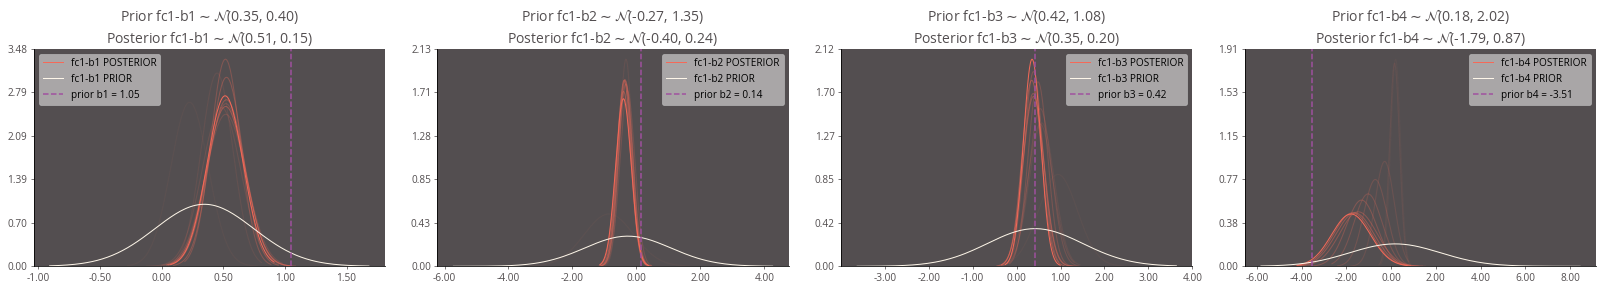

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

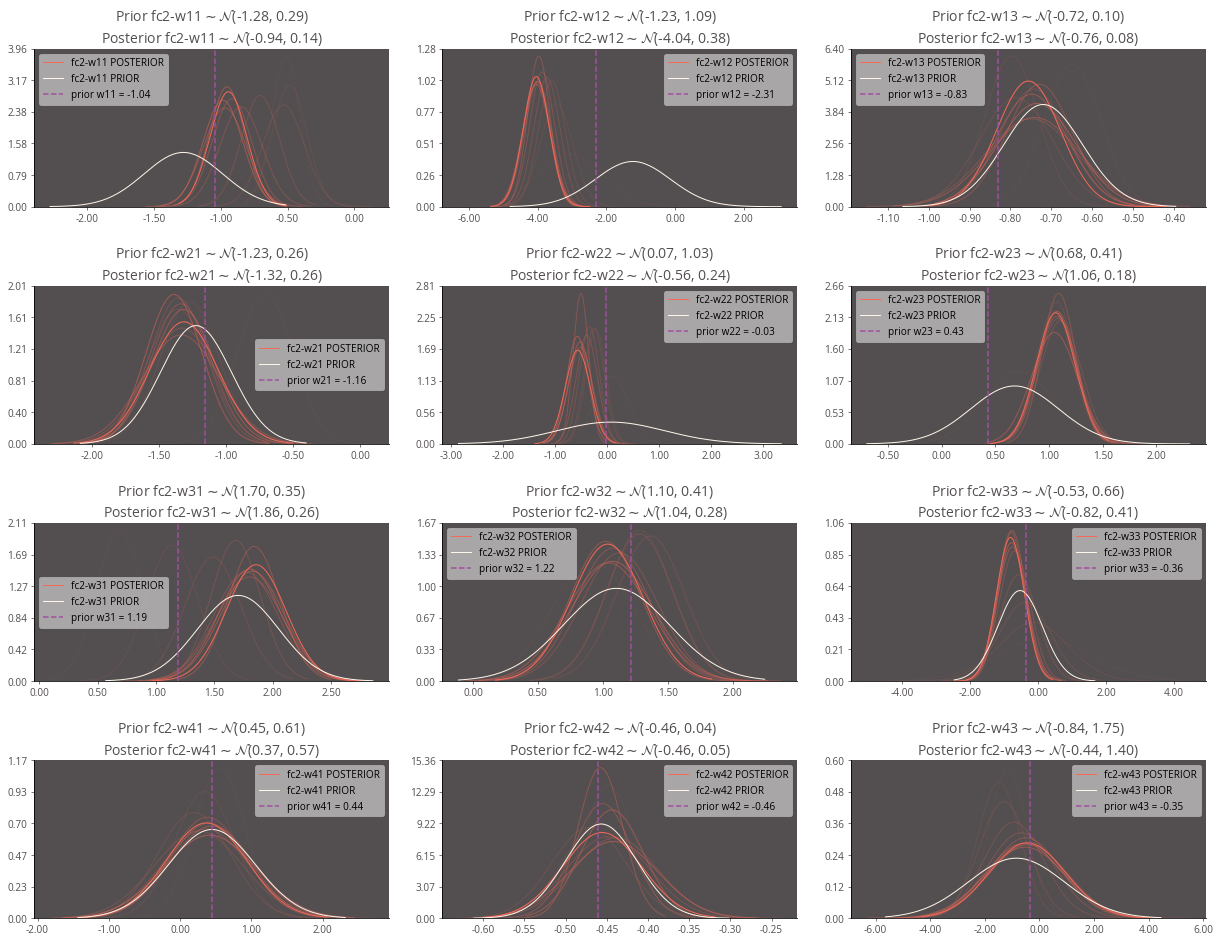

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 3, figsize=(21, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

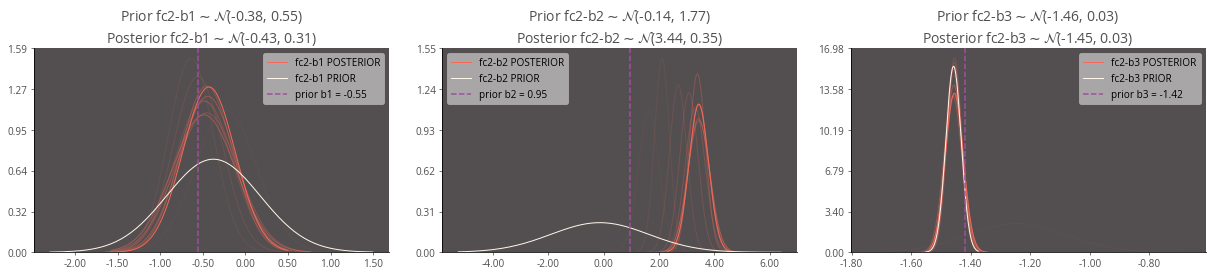

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

# **Sanity Check 6**


Data labeled using random initialization for the weights and biases distributions parameters
> $\mu_{_{SC}} \sim \mathcal{N}(0, 1) + c$  ,  where $c \sim \mathcal{U}(0, 1)$  
> $\sigma_{_{SC}} \sim \mathcal{N}(0, 1) $  
> $w, b \sim \mathcal{N}(\mu_{_{SC}}, \sigma_{_{SC}})$



In [ ]:
# Generate sanity-check data

def generate_labels(data):
    c = torch.rand(1)
    w1_loc = torch.randn(4, 2).float().T + c
    w1_scale = torch.abs(torch.randn(4, 2).float().T)
    w1_dist = torch.distributions.Normal(loc=w1_loc, scale=w1_scale)
    fc1_weight = []
    for _ in range(1):
        fc1_weight.append(w1_dist.sample())
    fc1_weight = torch.stack(fc1_weight)
    fc1_weight = fc1_weight.mean(dim=0)

    b1_loc = torch.randn(4).float() + c
    b1_scale = torch.abs(torch.randn(4).float())
    b1_dist = torch.distributions.Normal(loc=b1_loc, scale=b1_scale)
    fc1_bias = []
    for _ in range(1):
        fc1_bias.append(b1_dist.sample())
    fc1_bias = torch.stack(fc1_bias)
    fc1_bias = fc1_bias.mean(dim=0)
    
    w2_loc = torch.randn(3, 4).float().T + c
    w2_scale = torch.abs(torch.randn(3, 4).float().T)
    w2_dist = torch.distributions.Normal(loc=w2_loc, scale=w2_scale)
    fc2_weight = []
    for _ in range(1):
        fc2_weight.append(w2_dist.sample())
    fc2_weight = torch.stack(fc2_weight)
    fc2_weight = fc2_weight.mean(dim=0)

    b2_loc = torch.randn(3).float() + c
    b2_scale = torch.abs(torch.randn(3).float())
    b2_dist = torch.distributions.Normal(loc=b2_loc, scale=b2_scale)
    fc2_bias = []
    for _ in range(1):
        fc2_bias.append(b2_dist.sample())
    fc2_bias = torch.stack(fc2_bias)
    fc2_bias = fc2_bias.mean(dim=0)

    labels = torch.matmul(data, fc1_weight) + fc1_bias
    labels = F.relu(labels)
    labels = torch.matmul(labels, fc2_weight) + fc2_bias
    labels = F.log_softmax(labels)
    labels = labels.argmax(dim=1)

    priors_dict = {'w1_loc': w1_loc, 'w1_scale': w1_scale,
                   'b1_loc': b1_loc, 'b1_scale': b1_scale,
                   'w2_loc': w2_loc, 'w2_scale': w2_scale,
                   'b2_loc': b2_loc, 'b2_scale': b2_scale}

    return priors_dict, fc1_weight, fc1_bias, fc2_weight, fc2_bias, labels

fc1_weight = 
 tensor([[ 2.9209,  1.3647,  0.9573,  0.8204],
        [-0.1409,  1.8042,  1.3381,  0.8142]])

fc1_bias = 
 tensor([-1.9392,  1.0478,  0.6711, -0.0296])

fc2_weight = 
 tensor([[ 1.8391, -0.8607,  3.9682],
        [ 2.5736,  0.3518,  0.8421],
        [-0.0243,  0.3758,  2.8017],
        [-0.8086,  0.5098,  1.9792]])

fc2_bias = 
 tensor([ 1.0360,  1.0365, -0.7391])


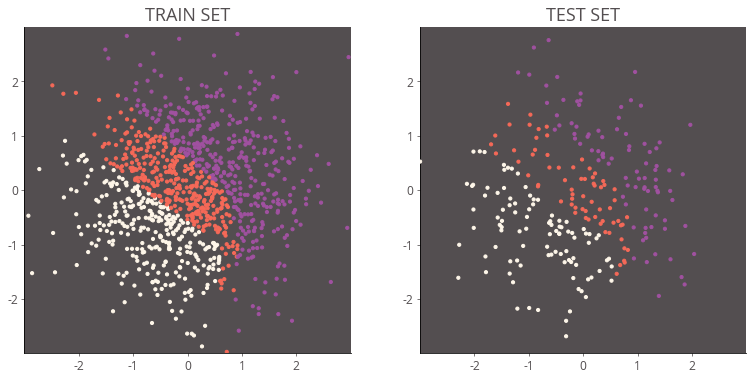

In [ ]:
# Create train and test sets

sc_data = torch.randn(1280, 2)
sc_priors_dict, sc_fc1_weight, sc_fc1_bias, sc_fc2_weight, sc_fc2_bias, sc_labels = generate_labels(sc_data)

print('fc1_weight = \n', sc_fc1_weight)
print('\nfc1_bias = \n', sc_fc1_bias)
print('\nfc2_weight = \n', sc_fc2_weight)
print('\nfc2_bias = \n', sc_fc2_bias)
# print('\n\n')

sc_train_data, sc_train_labels = sc_data[:1024], sc_labels[:1024]
sc_test_data, sc_test_labels = sc_data[1024:], sc_labels[1024:]
# print('Train Set : %4d samples - %s' % (len(sc_train_data), str(sc_train_data.shape)))
# print(' Test Set : %4d samples - %s' % (len(sc_test_data), str(sc_test_data.shape)))
# print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
visualize_multiclass_data(ax[0], sc_train_data, sc_train_labels, 'train set')
visualize_multiclass_data(ax[1], sc_test_data, sc_test_labels, 'test set')

In [ ]:
# Creating Dataloaders

sc_train_dataset = TensorDataset(sc_train_data, sc_train_labels)
sc_test_dataset = TensorDataset(sc_test_data, sc_test_labels)

sc_train_loader = DataLoader(sc_train_dataset, batch_size=128, drop_last=True)
sc_test_loader = DataLoader(sc_test_dataset, batch_size=128, drop_last=True)

print('Train batches : %d' % len(sc_train_loader))
print(' Test batches : %d' % len(sc_test_loader))

Train batches : 8
 Test batches : 2


### **Models**

In [ ]:
class DNN(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()

        self._fc1 = nn.Linear(in_size, hid_size)
        self._fc2 = nn.Linear(hid_size, out_size)

    def forward(self, x):

        x = self._fc1(x)
        x = F.relu(x)
        x = self._fc2(x)
        x = F.log_softmax(x)

        return x

In [ ]:
class BNN(nn.Module):
    def __init__(self, model_dnn, in_size, hid_size, out_size):
        super().__init__()

        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.model_dnn = model_dnn

    def model_bnn(self, x, y=None):
        _fc1w_prior = dist.Normal(loc=sc_priors_dict['w1_loc'].T,
                                  scale=sc_priors_dict['w1_scale'].T)
        _fc1b_prior = dist.Normal(loc=sc_priors_dict['b1_loc'].T,
                                  scale=sc_priors_dict['b1_scale'].T)
        
        _fc2w_prior = dist.Normal(loc=sc_priors_dict['w2_loc'].T,
                                  scale=sc_priors_dict['w2_scale'].T)
        _fc2b_prior = dist.Normal(loc=sc_priors_dict['b2_loc'].T,
                                  scale=sc_priors_dict['b2_scale'].T)
        
        priors_dict = {'_fc1.weight': _fc1w_prior,
                    '_fc1.bias': _fc1b_prior,
                    '_fc2.weight': _fc2w_prior,
                    '_fc2.bias': _fc2b_prior}
                    
        sampled_module = pyro.random_module('module', self.model_dnn, priors_dict)  
        sampled_model = sampled_module()
        logits = sampled_model(x)

        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y)

    def guide_bnn(self, x, y=None):
        _fc1w_loc = pyro.param('_fc1w_loc', torch.randn(self.hid_size, self.in_size))
        _fc1w_scale = torch.abs(pyro.param('_fc1w_scale', torch.randn(self.hid_size, self.in_size)))
        _fc1w_posterior = dist.Normal(loc=_fc1w_loc, scale=_fc1w_scale)

        _fc1b_loc = pyro.param('_fc1b_loc', torch.randn(self.hid_size))
        _fc1b_scale = torch.abs(pyro.param('_fc1b_scale', torch.randn(self.hid_size)))
        _fc1b_posterior = dist.Normal(loc=_fc1b_loc, scale=_fc1b_scale)

        _fc2w_loc = pyro.param('_fc2w_loc', torch.randn(self.out_size, self.hid_size))
        _fc2w_scale = torch.abs(pyro.param('_fc2w_scale', torch.randn(self.out_size, self.hid_size)))
        _fc2w_posterior = dist.Normal(loc=_fc2w_loc, scale=_fc2w_scale)
        
        _fc2b_loc = pyro.param('_fc2b_loc', torch.randn(self.out_size))
        _fc2b_scale = torch.abs(pyro.param('_fc2b_scale', torch.randn(self.out_size)))
        _fc2b_posterior = dist.Normal(loc=_fc2b_loc, scale=_fc2b_scale)
        
        posteriors_dict = {'_fc1.weight': _fc1w_posterior,
                    '_fc1.bias': _fc1b_posterior,
                    '_fc2.weight': _fc2w_posterior,
                    '_fc2.bias': _fc2b_posterior}
        
        sampled_module = pyro.random_module('module', self.model_dnn, posteriors_dict) 
        
        return sampled_module()

In [ ]:
# Define parameters and Initialize model

sc_model_dnn = DNN(2, 4, 3)

optimizer_dnn = torch.optim.Adam(sc_model_dnn.parameters(),
                                 lr=.001, weight_decay=.01) 
criterion_dnn = nn.NLLLoss()

sc_model_bdnn = DNN(2, 4, 3)
sc_bnn_ = BNN(sc_model_bdnn, 2, 4, 3)

optimizer_bnn = pyro.optim.Adam({'lr': .005})
svi = SVI(sc_bnn_.model_bnn, sc_bnn_.guide_bnn, optimizer_bnn, loss=Trace_ELBO())

In [ ]:
# Training process

sc_train_data_dnn = {'train_loss': [], 'train_acc': []}
sc_train_data_bnn = {'train_loss': [], 'train_acc': []}

log_interval = 100
num_epochs = 1000

pyro.clear_param_store()
for epoch in range(num_epochs):
    
    train_loss_dnn, train_acc_dnn = train_dnn(sc_model_dnn, sc_train_loader, 
                                              criterion_dnn, optimizer_dnn, epoch)
    train_loss_bnn, train_acc_bnn = train_bnn(sc_train_loader, svi, epoch)
    
    sc_train_data_dnn['train_loss'].append(train_loss_dnn)
    sc_train_data_dnn['train_acc'].append(train_acc_dnn)

    sc_train_data_bnn['train_loss'].append(train_loss_bnn)
    sc_train_data_bnn['train_acc'].append(train_acc_bnn)

    if epoch == 0:        
        inter_params_store = {key: [] for key in pyro.get_param_store()}

    if (epoch+1) % log_interval == 0 or epoch == 0 or (epoch+1) == num_epochs:
        print('\nEPOCH {:>2d}'.format(epoch+1))
        print('   DNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_dnn,
                                                               train_acc_dnn))
        print('   BNN loss: {:12.7f}   |   acc: {:.7f}'.format(train_loss_bnn,
                                                               train_acc_bnn))
        
        inter_ps =  pyro.get_param_store()
        for key, param in inter_ps.items():
            inter_params_store[key].append(param.detach().clone())


EPOCH  1
   DNN loss:    1.1279807   |   acc: 0.3095703
   BNN loss: 13810.9344390   |   acc: 0.2353516

EPOCH 100
   DNN loss:    0.4714617   |   acc: 0.8623047
   BNN loss:  346.9390822   |   acc: 0.8984375

EPOCH 200
   DNN loss:    0.2982564   |   acc: 0.9199219
   BNN loss:   70.3860338   |   acc: 0.9287109

EPOCH 300
   DNN loss:    0.2712555   |   acc: 0.9208984
   BNN loss:   68.9668224   |   acc: 0.9384766

EPOCH 400
   DNN loss:    0.2646426   |   acc: 0.9208984
   BNN loss:   61.8417732   |   acc: 0.9482422

EPOCH 500
   DNN loss:    0.2629128   |   acc: 0.9160156
   BNN loss:   57.6567673   |   acc: 0.9521484

EPOCH 600
   DNN loss:    0.2626416   |   acc: 0.9169922
   BNN loss:   56.5672260   |   acc: 0.9462891

EPOCH 700
   DNN loss:    0.2623324   |   acc: 0.9189453
   BNN loss:   56.8314407   |   acc: 0.9541016

EPOCH 800
   DNN loss:    0.2620097   |   acc: 0.9169922
   BNN loss:   59.6735003   |   acc: 0.9501953

EPOCH 900
   DNN loss:    0.2614394   |   acc: 0.92089

In [ ]:
ps =  pyro.get_param_store()
sc_params_store = dict()
for key, param in ps.items():
    sc_params_store[key] = param.detach().clone()

### **Performance**

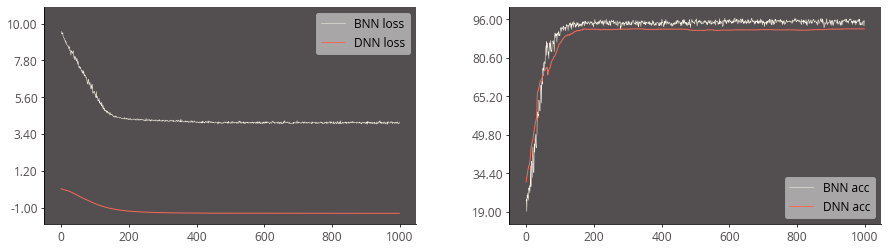

In [ ]:
# Display loss and accuracy

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'hspace': .5,
                                                          'wspace': .25})
  
train_loss_bnn = np.log(np.array(sc_train_data_bnn['train_loss']))
train_loss_dnn = np.log(np.array(sc_train_data_dnn['train_loss']))
plot_loss(ax[0], train_loss_bnn, train_loss_dnn)

train_acc_bnn = np.array(sc_train_data_bnn['train_acc'])*100
train_acc_dnn = np.array(sc_train_data_dnn['train_acc'])*100
plot_accuracies(ax[1], train_acc_bnn, train_acc_dnn)

In [ ]:
# Compute performance metrics

print('DEEP NEURAL NETWORK')
print('-' * 64)
sc_metrics_dnn = compute_performance_dnn(sc_model_dnn, sc_test_loader)

print('\n\nBAYESIAN NEURAL NETWORK')
print('-' * 64)
sc_metrics_bnn = compute_performance_bnn(sc_bnn_.guide_bnn, sc_test_loader)

DEEP NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        68
           1       0.95      0.99      0.97        99
           2       0.91      0.94      0.93        89

    accuracy                           0.93       256
   macro avg       0.93      0.92      0.92       256
weighted avg       0.93      0.93      0.93       256



BAYESIAN NEURAL NETWORK
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.93      0.93        68
           1       0.99      0.97      0.98        99
           2       0.96      0.99      0.97        89

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.97      0.96      0.96       256



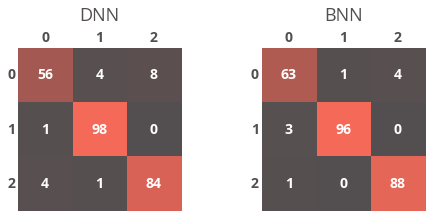

In [ ]:
# Display confusion matrix

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_confusion_matrix(ax[0], sc_metrics_dnn['conf_matrix'], 'dnn')
plot_confusion_matrix(ax[1], sc_metrics_bnn['conf_matrix'], 'bnn')

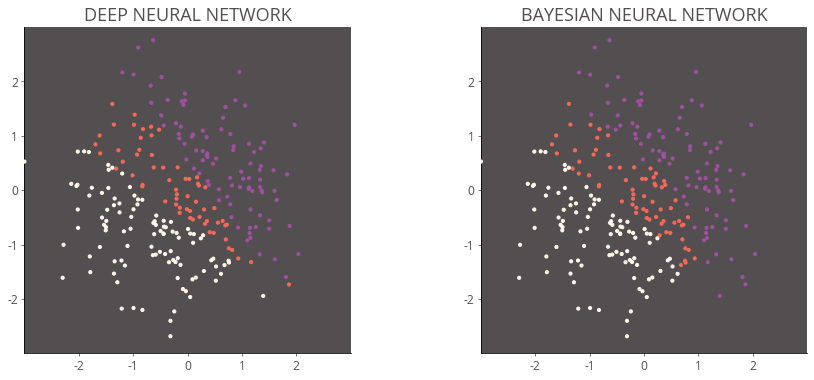

In [ ]:
# Display predictions for test data

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

visualize_multiclass_data(ax[0], sc_metrics_dnn['test_data'], sc_metrics_dnn['pred_labels'], 
                   'deep neural network')
visualize_multiclass_data(ax[1], sc_metrics_bnn['test_data'], sc_metrics_bnn['pred_labels'], 
                   'bayesian neural network')

## **Posterior distributions Analysis**

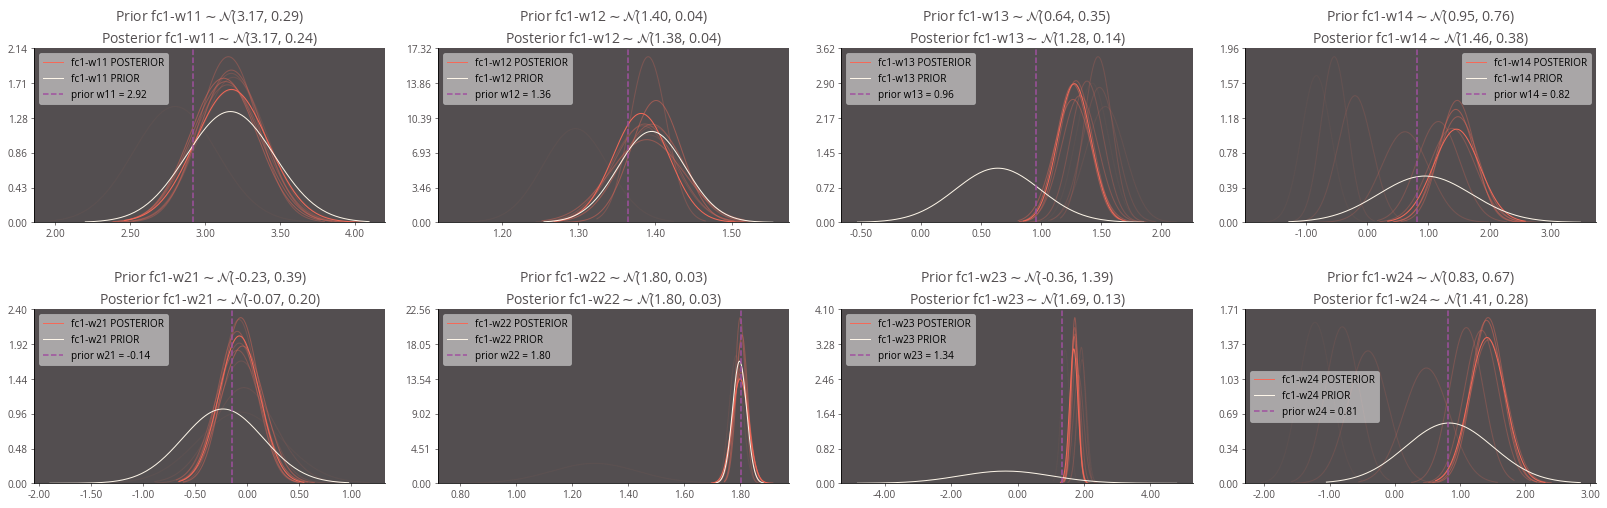

In [ ]:
# FC1 weight

fig, ax = plt.subplots(2, 4, figsize=(28, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc1_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post, 
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

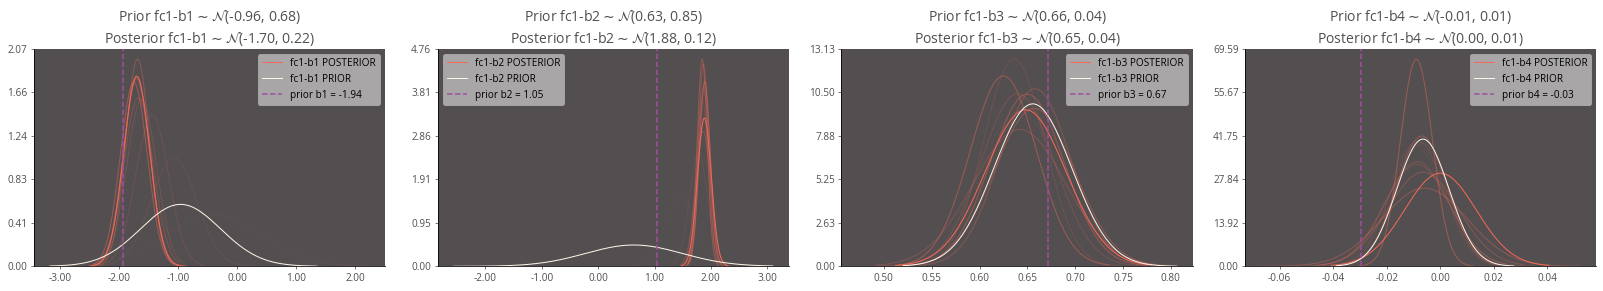

In [ ]:
# FC1 bias

fig, ax = plt.subplots(1, 4, figsize=(28, 4), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc1'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc1_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)

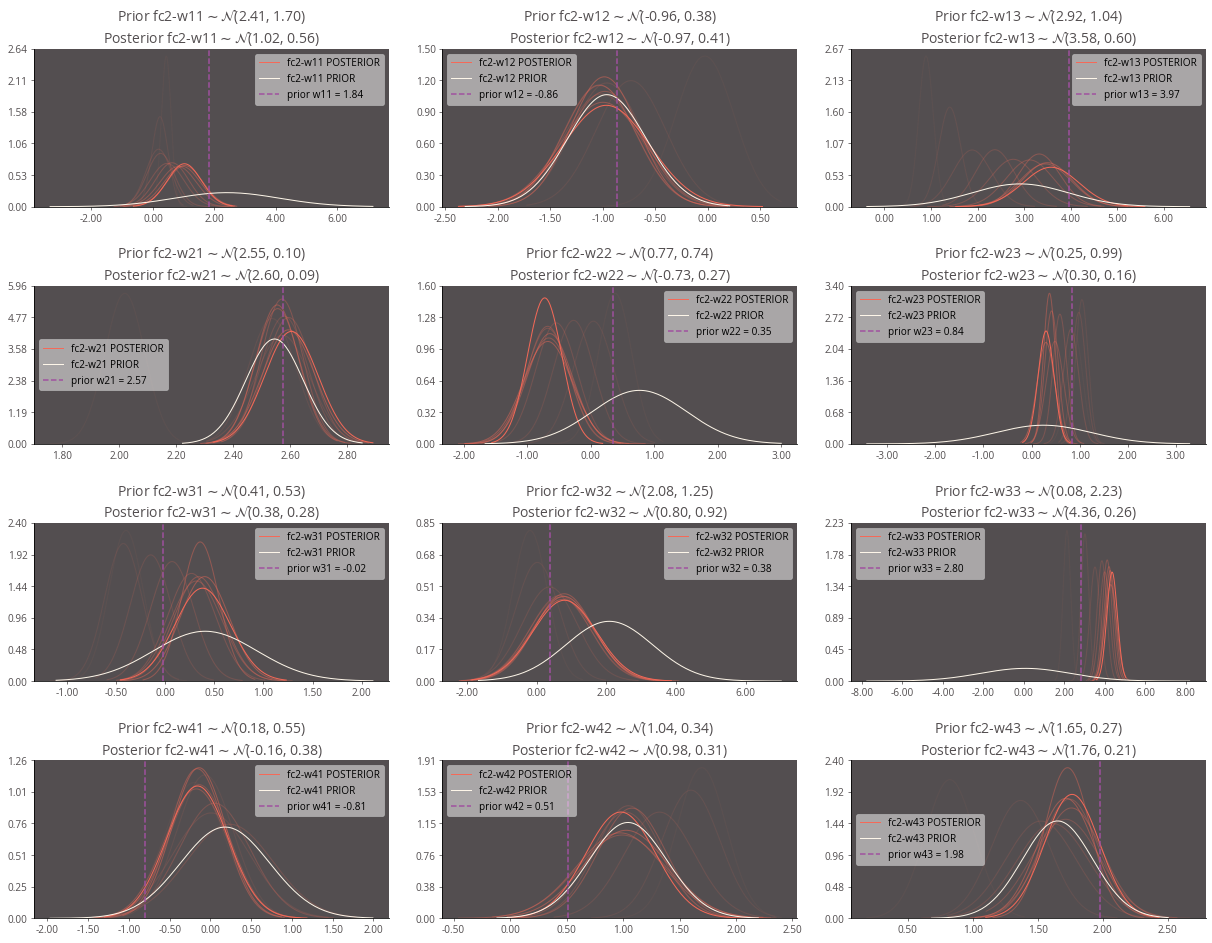

In [ ]:
# FC2 weight

fig, ax = plt.subplots(4, 3, figsize=(21, 16), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
w_loc = sc_params_store['_{:s}w_loc'.format(layer)].detach().numpy()
w_scale = np.abs(sc_params_store['_{:s}w_scale'.format(layer)].detach().numpy())
w_cols, w_rows = w_loc.shape

w_inter_loc = inter_params_store['_{:s}w_loc'.format(layer)][1:-1]
w_inter_scale = inter_params_store['_{:s}w_scale'.format(layer)][1:-1]

for row in range(w_rows):
    for col in range(w_cols):

        param_name = '{:s}-w{:d}{:d}'.format(layer, row+1, col+1)
        loc_post, scale_post = w_loc[col, row], w_scale[col, row]
        
        prior_name = 'w{:s}'.format(layer[-1])
        loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col, row]
        scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col, row]
        prior_value = sc_fc2_weight[row, col]

        inter_loc = [w[col, row] for w in w_inter_loc]
        inter_scale = [abs(w[col, row]) for w in w_inter_scale]

        display_posterior_pdf(ax[row, col], param_name, 
                              loc_post, scale_post,
                              prior_value, loc_prior, scale_prior,
                              inter_loc, inter_scale)

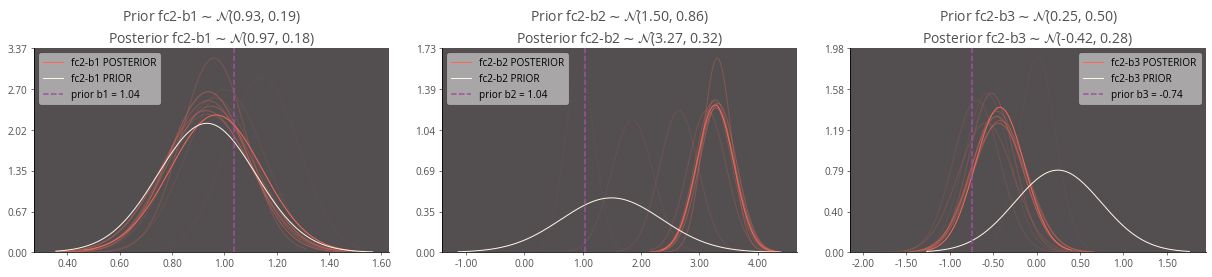

In [ ]:
# FC2 bias

fig, ax = plt.subplots(1, 3, figsize=(21, 3.75), 
                       gridspec_kw={'wspace': .15, 'hspace': .5})

layer = 'fc2'
b_loc = sc_params_store['_{:s}b_loc'.format(layer)].detach().numpy()
b_scale = np.abs(sc_params_store['_{:s}b_scale'.format(layer)].detach().numpy())
b_cols = b_loc.shape[0]
    
b_inter_loc = inter_params_store['_{:s}b_loc'.format(layer)][1:-1]
b_inter_scale = inter_params_store['_{:s}b_scale'.format(layer)][1:-1]

for col in range(b_cols):
    param_name = '{:s}-b{:d}'.format(layer, col+1)
    loc_post, scale_post = b_loc[col], b_scale[col]
        
    prior_name = 'b{:s}'.format(layer[-1])
    loc_prior = sc_priors_dict['{:s}_loc'.format(prior_name)].T[col]
    scale_prior = sc_priors_dict['{:s}_scale'.format(prior_name)].T[col]
    prior_value = sc_fc2_bias[col]

    inter_loc = [b[col] for b in b_inter_loc]
    inter_scale = [abs(b[col]) for b in b_inter_scale]

    display_posterior_pdf(ax[col], param_name, 
                          loc_post, scale_post,
                          prior_value, loc_prior, scale_prior,
                          inter_loc, inter_scale)